## PREPARE

datasets_yoo, audio, fine_output 폴더 만들기.

In [ ]:
#@title Connect and check GPU and runtime
from psutil import virtual_memory
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
ram_gb = virtual_memory().total / 1e9
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU', end="")
elif gpu_info.find('not found') >= 0:
    print('Not connected to a GPU', end="")
else:
    print('GPU Connected', end="")
print(', your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


GPU Connected, your runtime has 13.6 gigabytes of available RAM



### Setup Notebook, Install dependencies
<small>Run both cells to install system and needed functions.  
_If Colab for some reason crashes re-run cell 0.2 before contining._</small>


In [ ]:
#@title 0.1 - Install system
from IPython.display import clear_output
!git clone https://github.com/JonathanFly/bark.git
%cd bark
!pip install -r old_setup_files/requirements-pip.txt
!pip install encodec rich-argparse
!pip install librosa pydub devtools

#clear_output()
#print('Cell completed.')

Cloning into 'bark'...
remote: Enumerating objects: 1527, done.
remote: Counting objects: 100% (376/376), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 1527 (delta 334), reused 309 (delta 307), pack-reused 1151
Receiving objects: 100% (1527/1527), 19.82 MiB | 13.53 MiB/s, done.
Resolving deltas: 100% (776/776), done.
/content/bark
Ignoring sox: markers 'platform_system == "Darwin"' don't match your environment
Ignoring soundfile: markers 'platform_system == "Windows"' don't match your environment
Ignoring fairseq: markers 'platform_system == "Windows"' don't match your environment
Ignoring fairseq: markers 'platform_system == "Darwin"' don't match your environment
Ignoring pywin32: markers 'platform_system == "Windows"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 31.0 MB/s eta 0:00:00
  Installing build d

In [ ]:
 #@title 0.2 - Setup required functions and helpers
import os
import time
from bark_infinity import config
import numpy as np

logger = config.logger
logger.setLevel("WARNING")

from bark_infinity import generation #이걸 보고.. conversion 가능하게 수정..
from bark_infinity import api

import rich
from rich import print
from rich import pretty
from rich.pretty import pprint
from rich import inspect

import librosa
from pydub import AudioSegment
import ipywidgets as widgets
from IPython.display import display, Audio
from io import BytesIO

# None of this code, just fiddlign with Colab stuff
# Just to save Colab with outputs and float32 wavs are GIGANTO
# actually this doesn't work, the iPython widget converts it back to float32? or I messed up

def display_audio_int16_but(audio_arr_segments, file_name, sample_rate=generation.SAMPLE_RATE,  width='200px'):
    file_name_label = widgets.Label(value=f"Playing: {file_name}")
    file_name_label.layout.width = width
    audio_data_int16 = audio_arr_segments
    if isinstance(audio_data_int16, list):
        audio_data_int16 = np.concatenate(audio_data_int16)

    #audio_data_int16 = np.int16(audio_data_int16 * np.iinfo(np.int16).max)


    audio_widget = Audio(audio_data_int16, rate=sample_rate)
    display(file_name_label, audio_widget)


def on_button_click(button):
    audio_data, sample_rate = librosa.load(button.wav_path, sr=None)
    file_name = os.path.basename(button.wav_path)
    display_audio_int16_but(audio_data,file_name, sample_rate)

def display_wav_files(directory, matchType=".wav"):
    subdirs, wav_files = [], []

    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isfile(item_path) and item_path.endswith(matchType):
            wav_files.append(item_path)
        elif os.path.isdir(item_path):
            subdirs.append(item_path)

    wav_files.sort(key=lambda x: os.path.basename(x))

    for wav_file in wav_files:

        filename = os.path.basename(wav_file)
        print(f" {filename}")
        display( Audio(filename=wav_file, rate=generation.SAMPLE_RATE) )
        #button = widgets.Button(description=f"Play {filename}")
        #button.wav_path = wav_file
        #button.on_click(on_button_click)
        #display(button)

    for subdir in sorted(subdirs):
        print(f"<{subdir}>")
        display_wav_files(subdir, matchType)

def display_mp4_files(directory):
    return display_wav_files(directory, '.mp4')


### Gradio App

In [ ]:
#@markdown Run the WebUI with all features.<br>
#@markdown When loaded click the second link to launch WebUI in another window.
!python bark_webui.py --share

2023-12-03 08:51:23.226026: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 08:51:23.226094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 08:51:23.226133: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 08:51:24.689117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Pytorch version: 2.1
=== GPU Information ===
GPU Device: Tesla T4
Total memory: 14.74786376953125 GB
CUDA Version: 11.8
PyTorch Version: 2.1.0+cu118
   GPU Memory Free: 14.65 GB, Total: 14.75 GB
   >9 GB Memory Free, CPU Offloading Disabl

## TRAIN-VAL

### hubert model

In [ ]:

from bark.generation import _load_codec_model, generate_text_semantic
from encodec.utils import convert_audio

In [ ]:
import json
import os.path
from zipfile import ZipFile

import numpy
import torch
from torch import nn, optim
from torch.serialization import MAP_LOCATION


class CustomTokenizer(nn.Module):
    def __init__(self, hidden_size=1024, input_size=768, output_size=10000, version=0):
        super(CustomTokenizer, self).__init__()
        next_size = input_size
        if version == 0:
            self.lstm = nn.LSTM(input_size, hidden_size, 2, batch_first=True)
            next_size = hidden_size
        if version == 1:
            self.lstm = nn.LSTM(input_size, hidden_size, 2, batch_first=True)
            self.intermediate = nn.Linear(hidden_size, 4096)
            next_size = 4096

        self.fc = nn.Linear(next_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.optimizer: optim.Optimizer = None
        self.lossfunc = nn.CrossEntropyLoss()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.version = version

    def forward(self, x):
        x, _ = self.lstm(x)
        if self.version == 1:
            x = self.intermediate(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

    @torch.no_grad()
    def get_token(self, x):
        """
        Used to get the token for the first
        :param x: An array with shape (N, input_size) where N is a whole number greater or equal to 1, and input_size is the input size used when creating the model.
        :return: An array with shape (N,) where N is the same as N from the input. Every number in the array is a whole number in range 0...output_size - 1 where output_size is the output size used when creating the model.
        """
        return torch.argmax(self(x), dim=1)

    def prepare_training(self):
        self.optimizer = optim.Adam(self.parameters(), 0.001)

    def train_step(self, x_train, y_train, log_loss=False):
        # y_train = y_train[:-1]
        # y_train = y_train[1:]

        optimizer = self.optimizer
        lossfunc = self.lossfunc
        # Zero the gradients
        self.zero_grad()

        # Forward pass
        y_pred = self(x_train)

        y_train_len = len(y_train)
        y_pred_len = y_pred.shape[0]

        if y_train_len > y_pred_len:
            diff = y_train_len - y_pred_len
            y_train = y_train[diff:]
        elif y_train_len < y_pred_len:
            diff = y_pred_len - y_train_len
            y_pred = y_pred[:-diff, :]

        y_train_hot = torch.zeros(len(y_train), self.output_size)
        y_train_hot[range(len(y_train)), y_train] = 1
        y_train_hot = y_train_hot.to('cuda')

        # Calculate the loss
        loss = lossfunc(y_pred, y_train_hot)

        # Print loss
        if log_loss:
            print('Loss', loss.item())

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    def save(self, path):
        info_path = '.'.join(os.path.basename(path).split('.')[:-1]) + '/.info'
        torch.save(self.state_dict(), path)
        data_from_model = Data(self.input_size, self.hidden_size, self.output_size, self.version)
        with ZipFile(path, 'a') as model_zip:
            model_zip.writestr(info_path, data_from_model.save())
            model_zip.close()

    @staticmethod
    def load_from_checkpoint(path, map_location: MAP_LOCATION = None):
        old = True
        with ZipFile(path) as model_zip:
            filesMatch = [file for file in model_zip.namelist() if file.endswith('/.info')]
            file = filesMatch[0] if filesMatch else None
            if file:
                old = False
                data_from_model = Data.load(model_zip.read(file).decode('utf-8'))
            model_zip.close()
        if old:
            model = CustomTokenizer()
        else:
            model = CustomTokenizer(data_from_model.hidden_size, data_from_model.input_size, data_from_model.output_size, data_from_model.version)
        model.load_state_dict(torch.load(path))
        if map_location:
            model = model.to(map_location)
        return model



class Data:
    input_size: int
    hidden_size: int
    output_size: int
    version: int

    def __init__(self, input_size=768, hidden_size=1024, output_size=10000, version=0):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.version = version

    @staticmethod
    def load(string):
        data = json.loads(string)
        return Data(data['input_size'], data['hidden_size'], data['output_size'], data['version'])

    def save(self):
        data = {
            'input_size': self.input_size,
            'hidden_size': self.hidden_size,
            'output_size': self.output_size,
            'version': self.version,
        }
        return json.dumps(data)


def auto_train(data_path, save_path='model.pth', load_model: str | None = None, save_epochs=1):
    data_x, data_y = [], []

    if load_model and os.path.isfile(load_model):
        print('Loading model from', load_model)
        model_training = CustomTokenizer.load_from_checkpoint(load_model, 'cuda')
    else:
        print('Creating new model.')
        model_training = CustomTokenizer(version=1).to('cuda')  # Settings for the model to run without lstm
    save_path = os.path.join(data_path, save_path)
    base_save_path = '.'.join(save_path.split('.')[:-1])

    sem_string = '_semantic.npy'
    feat_string = '_semantic_features.npy'

    ready = os.path.join(data_path, 'ready')
    for input_file in os.listdir(ready):
        full_path = os.path.join(ready, input_file)
        if input_file.endswith(sem_string):
            data_y.append(numpy.load(full_path))
        elif input_file.endswith(feat_string):
            data_x.append(numpy.load(full_path))
    model_training.prepare_training()

    epoch = 1

    while 1:
        for i in range(save_epochs):
            j = 0
            for x, y in zip(data_x, data_y):
                model_training.train_step(torch.tensor(x).to('cuda'), torch.tensor(y).to('cuda'), j % 50 == 0)  # Print loss every 50 steps
                j += 1
        save_p = save_path
        save_p_2 = f'{base_save_path}_epoch_{epoch}.pth'
        model_training.save(save_p)
        model_training.save(save_p_2)
        print(f'Epoch {epoch} completed')
        epoch += 1

import os.path
import shutil
import urllib.request

import huggingface_hub


class HuBERTManager:
    @staticmethod
    def make_sure_hubert_installed(download_url: str = 'https://dl.fbaipublicfiles.com/hubert/hubert_base_ls960.pt', file_name: str = 'hubert.pt'):
        install_dir = os.path.join('data', 'models', 'hubert')
        if not os.path.isdir(install_dir):
            os.makedirs(install_dir, exist_ok=True)
        install_file = os.path.join(install_dir, file_name)
        if not os.path.isfile(install_file):
            print('Downloading HuBERT base model')
            urllib.request.urlretrieve(download_url, install_file)
            print('Downloaded HuBERT')
        return install_file


    @staticmethod
    def make_sure_tokenizer_installed(model: str = 'quantifier_hubert_base_ls960_14.pth', repo: str = 'GitMylo/bark-voice-cloning', local_file: str = 'tokenizer.pth'):
        install_dir = os.path.join('data', 'models', 'hubert')
        if not os.path.isdir(install_dir):
            os.makedirs(install_dir, exist_ok=True)
        install_file = os.path.join(install_dir, local_file)
        if not os.path.isfile(install_file):
            print('Downloading HuBERT custom tokenizer')
            huggingface_hub.hf_hub_download(repo, model, local_dir=install_dir, local_dir_use_symlinks=False)
            shutil.move(os.path.join(install_dir, model), install_file)
            print('Downloaded tokenizer')
        return install_file

from pathlib import Path

import torch
from torch import nn
from einops import pack, unpack

import fairseq

from torchaudio.functional import resample

from audiolm_pytorch.utils import curtail_to_multiple

import logging
logging.root.setLevel(logging.ERROR)


def exists(val):
    return val is not None


def default(val, d):
    return val if exists(val) else d


class CustomHubert(nn.Module):
    """
    checkpoint and kmeans can be downloaded at https://github.com/facebookresearch/fairseq/tree/main/examples/hubert
    or you can train your own
    """

    def __init__(
        self,
        checkpoint_path,
        target_sample_hz=16000,
        seq_len_multiple_of=None,
        output_layer=9,
        device=None
    ):
        super().__init__()
        self.target_sample_hz = target_sample_hz
        self.seq_len_multiple_of = seq_len_multiple_of
        self.output_layer = output_layer

        if device is not None:
            self.to(device)

        model_path = Path(checkpoint_path)

        assert model_path.exists(), f'path {checkpoint_path} does not exist'

        checkpoint = torch.load(checkpoint_path)
        load_model_input = {checkpoint_path: checkpoint}
        model, *_ = fairseq.checkpoint_utils.load_model_ensemble_and_task(load_model_input)

        if device is not None:
            model[0].to(device)

        self.model = model[0]
        self.model.eval()

    @property
    def groups(self):
        return 1

    @torch.no_grad()
    def forward(
        self,
        wav_input,
        flatten=True,
        input_sample_hz=None
    ):
        device = wav_input.device

        if exists(input_sample_hz):
            wav_input = resample(wav_input, input_sample_hz, self.target_sample_hz)

        if exists(self.seq_len_multiple_of):
            wav_input = curtail_to_multiple(wav_input, self.seq_len_multiple_of)

        embed = self.model(
            wav_input,
            features_only=True,
            mask=False,  # thanks to @maitycyrus for noticing that mask is defaulted to True in the fairseq code
            output_layer=self.output_layer
        )

        embed, packed_shape = pack([embed['x']], '* d')

        # codebook_indices = self.kmeans.predict(embed.cpu().detach().numpy())

        codebook_indices = torch.from_numpy(embed.cpu().detach().numpy()).to(device)  # .long()

        if flatten:
            return codebook_indices

        codebook_indices, = unpack(codebook_indices, packed_shape, '*')
        return codebook_indices



### import things

In [ ]:

import torch
import torch.nn as nn
import os
import re
import gc
import json
import math
import hashlib
import numpy as np
import logging
import torchaudio
from tqdm.auto import tqdm
import torch.nn.functional as F
from encodec.utils import convert_audio
from accelerate import Accelerator
from accelerate.utils import set_seed
from transformers import BertTokenizer
from huggingface_hub import hf_hub_download
from packaging import version
from diffusers.optimization import get_scheduler
%cd /content/bark/bark
from model import GPTConfig, GPT
from model_fine import FineGPT, FineGPTConfig #model 앞 . 없애

/content/bark/bark


### 없는 모듈 설치 및 드라이브 접근

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content

import warnings
import sys
import importlib.util
from copy import deepcopy
import copy
import json
import os
from dataclasses import dataclass

from typing import Any, Tuple, Union, Dict

from packaging import version

if sys.version_info < (3, 8):
    import importlib_metadata
else:
    import importlib.metadata as importlib_metadata


def _is_package_available(pkg_name: str, return_version: bool = False) -> Union[Tuple[bool, str], bool]:
    # Check we're not importing a "pkg_name" directory somewhere but the actual library by trying to grab the version
    package_exists = importlib.util.find_spec(pkg_name) is not None
    package_version = "N/A"
    if package_exists:
        try:
            package_version = importlib_metadata.version(pkg_name)
            package_exists = True
        except importlib_metadata.PackageNotFoundError:
            package_exists = False
    if return_version:
        return package_exists, package_version
    else:
        return package_exists

_accelerate_available, _accelerate_version = _is_package_available("accelerate", return_version=True)
_bitsandbytes_available = _is_package_available("bitsandbytes")
_torch_available, _torch_version = _is_package_available("torch", return_version=True)

def is_accelerate_available(check_partial_state=False):
    if check_partial_state:
        return _accelerate_available and version.parse(_accelerate_version) >= version.parse("0.19.0")
    return _accelerate_available

def is_bitsandbytes_available():
    return _bitsandbytes_available

def is_torch_available():
    return _torch_available

if is_bitsandbytes_available():
    import bitsandbytes as bnb
    import torch
    import torch.nn as nn

if is_accelerate_available():
    from accelerate import init_empty_weights
    from accelerate.utils import find_tied_parameters


def set_module_quantized_tensor_to_device(module, tensor_name, device, value=None, fp16_statistics=None):
    """
    A helper function to set a given tensor (parameter of buffer) of a module on a specific device (note that doing
    `param.to(device)` creates a new tensor not linked to the parameter, which is why we need this function). The
    function is adapted from `set_module_tensor_to_device` function from accelerate that is adapted to support the
    class `Int8Params` from `bitsandbytes`.

    Args:
        module (`torch.nn.Module`):
            The module in which the tensor we want to move lives.
        tensor_name (`str`):
            The full name of the parameter/buffer.
        device (`int`, `str` or `torch.device`):
            The device on which to set the tensor.
        value (`torch.Tensor`, *optional*):
            The value of the tensor (useful when going from the meta device to any other device).
        fp16_statistics (`torch.HalfTensor`, *optional*):
            The list of fp16 statistics to set on the module, used for serialization.
    """
    # Recurse if needed
    if "." in tensor_name:
        splits = tensor_name.split(".")
        for split in splits[:-1]:
            new_module = getattr(module, split)
            if new_module is None:
                raise ValueError(f"{module} has no attribute {split}.")
            module = new_module
        tensor_name = splits[-1]

    if tensor_name not in module._parameters and tensor_name not in module._buffers:
        raise ValueError(f"{module} does not have a parameter or a buffer named {tensor_name}.")
    is_buffer = tensor_name in module._buffers
    old_value = getattr(module, tensor_name)

    if old_value.device == torch.device("meta") and device not in ["meta", torch.device("meta")] and value is None:
        raise ValueError(f"{tensor_name} is on the meta device, we need a `value` to put in on {device}.")

    is_4bit = False
    is_8bit = False
    if is_buffer or not is_bitsandbytes_available():
        is_8bit = False
        is_4bit = False
    else:
        is_4bit = hasattr(bnb.nn, "Params4bit") and isinstance(module._parameters[tensor_name], bnb.nn.Params4bit)
        is_8bit = isinstance(module._parameters[tensor_name], bnb.nn.Int8Params)

    if is_8bit or is_4bit:
        param = module._parameters[tensor_name]
        if param.device.type != "cuda":
            if value is None:
                new_value = old_value.to(device)
            elif isinstance(value, torch.Tensor):
                new_value = value.to("cpu")
                if value.dtype == torch.int8:
                    is_8bit_serializable = version.parse(importlib_metadata.version("bitsandbytes")) > version.parse(
                        "0.37.2"
                    )
                    if not is_8bit_serializable:
                        raise ValueError(
                            "Detected int8 weights but the version of bitsandbytes is not compatible with int8 serialization. "
                            "Make sure to download the latest `bitsandbytes` version. `pip install --upgrade bitsandbytes`."
                        )
            else:
                new_value = torch.tensor(value, device="cpu")

            kwargs = old_value.__dict__
            if is_8bit:
                new_value = bnb.nn.Int8Params(new_value, requires_grad=False, **kwargs).to(device)
            elif is_4bit:
                new_value = bnb.nn.Params4bit(new_value, requires_grad=False, **kwargs).to(device)

            module._parameters[tensor_name] = new_value
            if fp16_statistics is not None:
                setattr(module.weight, "SCB", fp16_statistics.to(device))

    else:
        if value is None:
            new_value = old_value.to(device)
        elif isinstance(value, torch.Tensor):
            new_value = value.to(device)
        else:
            new_value = torch.tensor(value, device=device)

        if is_buffer:
            module._buffers[tensor_name] = new_value
        else:
            new_value = nn.Parameter(new_value, requires_grad=old_value.requires_grad)
            module._parameters[tensor_name] = new_value


def replace_with_bnb_linear(model, modules_to_not_convert=None, current_key_name=None, quantization_config=None):
    """
    A helper function to replace all `torch.nn.Linear` modules by `bnb.nn.Linear8bit` modules from the `bitsandbytes`
    library. This will enable running your models using mixed int8 precision as described by the paper `LLM.int8():
    8-bit Matrix Multiplication for Transformers at Scale`. Make sure `bitsandbytes` compiled with the correct CUDA
    version of your hardware is installed before running this function. `pip install -i https://test.pypi.org/simple/
    bitsandbytes`

    The function will be run recursively and replace all `torch.nn.Linear` modules except for the `lm_head` that should
    be kept as a `torch.nn.Linear` module. The replacement is done under `init_empty_weights` context manager so no
    CPU/GPU memory is required to run this function. Int8 mixed-precision matrix decomposition works by separating a
    matrix multiplication into two streams: (1) and systematic feature outlier stream matrix multiplied in fp16
    (0.01%), (2) a regular stream of int8 matrix multiplication (99.9%). With this method, int8 inference with no
    predictive degradation is possible for very large models (>=176B parameters).

    Parameters:
        model (`torch.nn.Module`):
            Input model or `torch.nn.Module` as the function is run recursively.
        modules_to_not_convert (`List[`str`]`, *optional*, defaults to `["lm_head"]`):
            Names of the modules to not convert in `Linear8bitLt`. In practice we keep the `lm_head` in full precision
            for numerical stability reasons.
        current_key_name (`List[`str`]`, *optional*):
            An array to track the current key of the recursion. This is used to check whether the current key (part of
            it) is not in the list of modules to not convert (for instances modules that are offloaded to `cpu` or
            `disk`).
    """
    modules_to_not_convert = ["lm_head"] if modules_to_not_convert is None else modules_to_not_convert
    for name, module in model.named_children():
        if current_key_name is None:
            current_key_name = []

        if isinstance(module, nn.Linear) and name not in modules_to_not_convert:
            # Check if the current key is not in the `modules_to_not_convert`
            if not any(key in ".".join(current_key_name) for key in modules_to_not_convert):
                with init_empty_weights():
                    if quantization_config.quantization_method() == "llm_int8":
                        model._modules[name] = bnb.nn.Linear8bitLt(
                            module.in_features,
                            module.out_features,
                            module.bias is not None,
                            has_fp16_weights=quantization_config.llm_int8_has_fp16_weight,
                            threshold=quantization_config.llm_int8_threshold,
                        )
                    else:
                        if (
                            quantization_config.llm_int8_skip_modules is not None
                            and name in quantization_config.llm_int8_skip_modules
                        ):
                            pass
                        else:
                            model._modules[name] = bnb.nn.Linear4bit(
                                module.in_features,
                                module.out_features,
                                module.bias is not None,
                                quantization_config.bnb_4bit_compute_dtype,
                                compress_statistics=quantization_config.bnb_4bit_use_double_quant,
                                quant_type=quantization_config.bnb_4bit_quant_type,
                            )
                    # Force requires grad to False to avoid unexpected errors
                    model._modules[name].requires_grad_(False)
        # Remove the last key for recursion
        if len(list(module.children())) > 0:
            replace_with_bnb_linear(
                module,
                modules_to_not_convert,
                current_key_name,
                quantization_config,
            )
    return model


# For backward compatibility
def replace_8bit_linear(*args, **kwargs):
    warnings.warn(
        "`replace_8bit_linear` will be deprecated in a future version, please use `replace_with_bnb_linear` instead",
        FutureWarning,
    )
    return replace_with_bnb_linear(*args, **kwargs)


# For backward compatiblity
def set_module_8bit_tensor_to_device(*args, **kwargs):
    warnings.warn(
        "`set_module_8bit_tensor_to_device` will be deprecated in a future version, please use `set_module_quantized_tensor_to_device` instead",
        FutureWarning,
    )
    return set_module_quantized_tensor_to_device(*args, **kwargs)


def get_keys_to_not_convert(model):
    r"""
    An utility function to get the key of the module to keep in full precision if any For example for CausalLM modules
    we may want to keep the lm_head in full precision for numerical stability reasons. For other architectures, we want
    to keep the tied weights of the model. The function will return a list of the keys of the modules to not convert in
    int8.

    Parameters:
    model (`torch.nn.Module`):
        Input model
    """
    # Create a copy of the model and tie the weights, then
    # check if it contains tied weights
    tied_model = deepcopy(model)  # this has 0 cost since it is done inside `init_empty_weights` context manager`
    tied_model.tie_weights()

    tied_params = find_tied_parameters(tied_model)
    # For compatibility with Accelerate < 0.18
    if isinstance(tied_params, dict):
        tied_keys = list(tied_params.values())
    else:
        tied_keys = sum([x[1:] for x in tied_params], [])
    has_tied_params = len(tied_keys) > 0

    # Check if it is a base model
    is_base_model = not hasattr(model, model.base_model_prefix)

    # Ignore this for base models (BertModel, GPT2Model, etc.)
    if (not has_tied_params) and is_base_model:
        return []

    # otherwise they have an attached head
    list_modules = list(model.named_parameters())
    list_last_module = [list_modules[-1][0]]

    # add last module together with tied weights
    intersection = set(list_last_module) - set(tied_keys)
    list_untouched = tied_keys + list(intersection)

    # remove ".weight" from the keys
    names_to_remove = [".weight", ".bias"]
    filtered_module_names = []
    for name in list_untouched:
        for name_to_remove in names_to_remove:
            if name_to_remove in name:
                name = name.replace(name_to_remove, "")
        filtered_module_names.append(name)

    return filtered_module_names

#!/usr/bin/env python
# coding=utf-8

# Copyright 2023 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



if is_torch_available():
    import torch


@dataclass
class BitsAndBytesConfig:
    """
    This is a wrapper class about all possible attributes and features that you can play with a model that has been
    loaded using `bitsandbytes`.

    This replaces `load_in_8bit` or `load_in_4bit`therefore both options are mutually exclusive.

    Currently only supports `LLM.int8()`, `FP4`, and `NF4` quantization. If more methods are added to `bitsandbytes`,
    then more arguments will be added to this class.

    Args:
        load_in_8bit (`bool`, *optional*, defaults to `False`):
            This flag is used to enable 8-bit quantization with LLM.int8().
        load_in_4bit (`bool`, *optional*, defaults to `False`):
            This flag is used to enable 4-bit quantization by replacing the Linear layers with FP4/NF4 layers from
            `bitsandbytes`.
        llm_int8_threshold (`float`, *optional*, defaults to 6):
            This corresponds to the outlier threshold for outlier detection as described in `LLM.int8() : 8-bit Matrix
            Multiplication for Transformers at Scale` paper: https://arxiv.org/abs/2208.07339 Any hidden states value
            that is above this threshold will be considered an outlier and the operation on those values will be done
            in fp16. Values are usually normally distributed, that is, most values are in the range [-3.5, 3.5], but
            there are some exceptional systematic outliers that are very differently distributed for large models.
            These outliers are often in the interval [-60, -6] or [6, 60]. Int8 quantization works well for values of
            magnitude ~5, but beyond that, there is a significant performance penalty. A good default threshold is 6,
            but a lower threshold might be needed for more unstable models (small models, fine-tuning).
        llm_int8_skip_modules (`List[str]`, *optional*):
            An explicit list of the modules that we do not want to convert in 8-bit. This is useful for models such as
            Jukebox that has several heads in different places and not necessarily at the last position. For example
            for `CausalLM` models, the last `lm_head` is kept in its original `dtype`.
        llm_int8_enable_fp32_cpu_offload (`bool`, *optional*, defaults to `False`):
            This flag is used for advanced use cases and users that are aware of this feature. If you want to split
            your model in different parts and run some parts in int8 on GPU and some parts in fp32 on CPU, you can use
            this flag. This is useful for offloading large models such as `google/flan-t5-xxl`. Note that the int8
            operations will not be run on CPU.
        llm_int8_has_fp16_weight (`bool`, *optional*, defaults to `False`):
            This flag runs LLM.int8() with 16-bit main weights. This is useful for fine-tuning as the weights do not
            have to be converted back and forth for the backward pass.
        bnb_4bit_compute_dtype (`torch.dtype` or str, *optional*, defaults to `torch.float32`):
            This sets the computational type which might be different than the input time. For example, inputs might be
            fp32, but computation can be set to bf16 for speedups.
        bnb_4bit_quant_type (`str`, {fp4, fn4}, defaults to `fp4`):
            This sets the quantization data type in the bnb.nn.Linear4Bit layers. Options are FP4 and NF4 data types
            which are specified by `fp4` or `fn4`.
        bnb_4bit_use_double_quant (`bool`, *optional*, defaults to `False`):
            This flag is used for nested quantization where the quantization constants from the first quantization are
            quantized again.
        kwargs (`Dict[str, Any]`, *optional*):
            Additional parameters from which to initialize the configuration object.
    """

    def __init__(
        self,
        load_in_8bit=False,
        load_in_4bit=False,
        llm_int8_threshold=6.0,
        llm_int8_skip_modules=None,
        llm_int8_enable_fp32_cpu_offload=False,
        llm_int8_has_fp16_weight=False,
        bnb_4bit_compute_dtype=None,
        bnb_4bit_quant_type="fp4",
        bnb_4bit_use_double_quant=False,
        **kwargs,
    ):
        self.load_in_8bit = load_in_8bit
        self.load_in_4bit = load_in_4bit
        self.llm_int8_threshold = llm_int8_threshold
        self.llm_int8_skip_modules = llm_int8_skip_modules
        self.llm_int8_enable_fp32_cpu_offload = llm_int8_enable_fp32_cpu_offload
        self.llm_int8_has_fp16_weight = llm_int8_has_fp16_weight
        self.bnb_4bit_quant_type = bnb_4bit_quant_type
        self.bnb_4bit_use_double_quant = bnb_4bit_use_double_quant

        if bnb_4bit_compute_dtype is None:
            self.bnb_4bit_compute_dtype = torch.float32
        elif isinstance(bnb_4bit_compute_dtype, str):
            self.bnb_4bit_compute_dtype = getattr(torch, bnb_4bit_compute_dtype)
        elif isinstance(bnb_4bit_compute_dtype, torch.dtype):
            self.bnb_4bit_compute_dtype = bnb_4bit_compute_dtype
        else:
            raise ValueError("bnb_4bit_compute_dtype must be a string or a torch.dtype")

        self.post_init()

    def post_init(self):
        r"""
        Safety checker that arguments are correct - also replaces some NoneType arguments with their default values.
        """
        if not isinstance(self.llm_int8_threshold, float):
            raise ValueError("llm_int8_threshold must be a float")

        if self.llm_int8_skip_modules is not None and not isinstance(self.llm_int8_skip_modules, list):
            raise ValueError("llm_int8_skip_modules must be a list of strings")
        if not isinstance(self.llm_int8_enable_fp32_cpu_offload, bool):
            raise ValueError("llm_int8_enable_fp32_cpu_offload must be a boolean")

        if not isinstance(self.llm_int8_has_fp16_weight, bool):
            raise ValueError("llm_int8_has_fp16_weight must be a boolean")

        if self.bnb_4bit_compute_dtype is not None and not isinstance(self.bnb_4bit_compute_dtype, torch.dtype):
            raise ValueError("bnb_4bit_compute_dtype must be torch.dtype")

        if not isinstance(self.bnb_4bit_quant_type, str):
            raise ValueError("bnb_4bit_quant_type must be a string")

        if not isinstance(self.bnb_4bit_use_double_quant, bool):
            raise ValueError("bnb_4bit_use_double_quant must be a boolean")

        if self.load_in_4bit and not version.parse(importlib_metadata.version("bitsandbytes")) >= version.parse(
            "0.39.0"
        ):
            raise ValueError(
                "4 bit quantization requires bitsandbytes>=0.39.0 - please upgrade your bitsandbytes version"
            )

    def is_quantizable(self):
        r"""
        Returns `True` if the model is quantizable, `False` otherwise.
        """
        return self.load_in_8bit or self.load_in_4bit

    def quantization_method(self):
        r"""
        This method returns the quantization method used for the model. If the model is not quantizable, it returns
        `None`.
        """
        if self.load_in_8bit:
            return "llm_int8"
        elif self.load_in_4bit and self.bnb_4bit_quant_type == "fp4":
            return "fp4"
        elif self.load_in_4bit and self.bnb_4bit_quant_type == "nf4":
            return "nf4"
        else:
            return None

    @classmethod
    def from_dict(cls, config_dict, return_unused_kwargs, **kwargs):
        """
        Instantiates a [`BitsAndBytesConfig`] from a Python dictionary of parameters.

        Args:
            config_dict (`Dict[str, Any]`):
                Dictionary that will be used to instantiate the configuration object.
            return_unused_kwargs (`bool`):
                Whether or not to return a list of unused keyword arguments. Used for `from_pretrained` method in
                `PreTrainedModel`.
            kwargs (`Dict[str, Any]`):
                Additional parameters from which to initialize the configuration object.

        Returns:
            [`BitsAndBytesConfig`]: The configuration object instantiated from those parameters.
        """

        config = cls(**config_dict)

        to_remove = []
        for key, value in kwargs.items():
            if hasattr(config, key):
                setattr(config, key, value)
                to_remove.append(key)
        for key in to_remove:
            kwargs.pop(key, None)

        if return_unused_kwargs:
            return config, kwargs
        else:
            return config

    def to_json_file(self, json_file_path: Union[str, os.PathLike]):
        """
        Save this instance to a JSON file.

        Args:
            json_file_path (`str` or `os.PathLike`):
                Path to the JSON file in which this configuration instance's parameters will be saved.
            use_diff (`bool`, *optional*, defaults to `True`):
                If set to `True`, only the difference between the config instance and the default
                `BitsAndBytesConfig()` is serialized to JSON file.
        """
        with open(json_file_path, "w", encoding="utf-8") as writer:
            config_dict = self.to_dict()
            json_string = json.dumps(config_dict, indent=2, sort_keys=True) + "\n"

            writer.write(json_string)

    def to_dict(self) -> Dict[str, Any]:
        """
        Serializes this instance to a Python dictionary. Returns:
            `Dict[str, Any]`: Dictionary of all the attributes that make up this configuration instance.
        """

        output = copy.deepcopy(self.__dict__)
        output["bnb_4bit_compute_dtype"] = str(output["bnb_4bit_compute_dtype"]).split(".")[1]

        return output



/content


In [ ]:
# Adapted from https://github.com/microsoft/DeepSpeedExamples/blob/master/applications/DeepSpeed-Chat/training/utils/module/lora.py

import math
import torch
from torch import nn
import torch.nn.functional as F

class LinearLayer_LoRA(nn.Module):
    # a simple implementation of LoRA
    def __init__(self,
                 weight,
                 lora_dim=0,
                 lora_scaling=1,
                 lora_dropout=0,
                 bias=None):
        super(LinearLayer_LoRA, self).__init__()
        self.weight = weight
        self.bias = bias

        if lora_dim <= 0:
            raise ValueError(
                "You are training to use LoRA, whose reduced dim should be larger than 1"
            )

        rows, columns = weight.shape
        self.lora_right_weight = nn.Parameter(torch.zeros(
            columns,
            lora_dim))  # apply transpose so in forward we do not need to
        self.lora_left_weight = nn.Parameter(torch.zeros(lora_dim, rows))
        self.lora_scaling = lora_scaling / lora_dim

        if lora_dropout > 0:
            self.lora_dropout = nn.Dropout(lora_dropout)
        else:
            self.lora_dropout = nn.Identity()

        self.reset_parameters()
        # disable the original weight gradient
        self.weight.requires_grad = False
        # fuse LoRA to the original weight
        self.fuse_lora = False

    def eval(self):
        self.lora_dropout.eval()

    #   self.fuse_lora_weight()

    def train(self, mode=True):
        self.lora_dropout.train(mode)
        # self.unfuse_lora_weight()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.lora_right_weight, a=math.sqrt(5))
        nn.init.zeros_(self.lora_left_weight)

    def fuse_lora_weight(self):
        if not self.fuse_lora:
            self.weight.data += self.lora_scaling * torch.matmul(
                self.lora_left_weight.t(), self.lora_right_weight.t())
        self.fuse_lora = True

    def unfuse_lora_weight(self):
        if self.fuse_lora:
            self.weight.data -= self.lora_scaling * torch.matmul(
                self.lora_left_weight.t(), self.lora_right_weight.t())
        self.fuse_lora = False

    def forward(self, input):
        if self.fuse_lora:
            return F.linear(input, self.weight, self.bias)
        else:
            return F.linear(
                input, self.weight,
                self.bias) + (self.lora_dropout(input) @ self.lora_right_weight
                              @ self.lora_left_weight) * self.lora_scaling


def recursive_getattr(model, module_name):
    """
    From https://github.com/microsoft/DeepSpeed/blob/master/deepspeed/compression/helper.py
    Recursively get the attribute of a module.
    Args:
        model (`torch.nn.Module`)
            The model to get the attribute from.
        module_name (`str`)
            The name of the module to get the attribute from.
    """
    split_list = module_name.split('.')
    output = model
    for name in split_list:
        output = getattr(output, name)
    return output


def recursive_setattr(model, module_name, module):
    """
    From https://github.com/microsoft/DeepSpeed/blob/master/deepspeed/compression/helper.py
    Recursively set the attribute of a module.
    Args:
        model (`torch.nn.Module`)
            The model to set the attribute in.
        module_name (`str`)
            The name of the module to set the attribute in.
        module (`torch.nn.Module`)
            The module to set the attribute to.
    """
    split_list = module_name.split('.')
    output = model
    for name in split_list[:-1]:
        output = getattr(output, name)
    output.__setattr__(split_list[-1], module)


# convert the linear layer to LoRA
def convert_linear_layer_to_lora(model,
                                 part_module_name,
                                 lora_dim=0,
                                 lora_scaling=1,
                                 lora_dropout=0):
    replace_name = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) and part_module_name in name:
            replace_name.append(name)
    for name in replace_name:
        module = recursive_getattr(model, name)
        tmp = LinearLayer_LoRA(
            module.weight, lora_dim, lora_scaling, lora_dropout,
            module.bias).to(module.weight.device).to(module.weight.dtype)
        recursive_setattr(model, name, tmp)
    return model


# convert the LoRA layer to linear layer
def convert_lora_to_linear_layer(model):
    replace_name = []
    for name, module in model.named_modules():
        if isinstance(module, LinearLayer_LoRA):
            replace_name.append(name)
    for name in replace_name:
        module = recursive_getattr(model, name)
        module.fuse_lora_weight()
    return model


def only_optimize_lora_parameters(model):
    # turn off the gradient of all the parameters except the LoRA parameters
    for name, param in model.named_parameters():
        if "lora_right_weight" in name or "lora_left_weight" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    return model

### set up- fine

In [ ]:
train_batch_size = 2
eval_batch_size = 2
grad_accum = 2
ckpt_path = 'models/fine_2.pt'
model_type = "fine"
dataset_path = '/content/drive/MyDrive/datasets_yoo/' #만들어줘
logging_dir = 'logs/'
log_with = 'wandb'
hubert_path = 'data/models/hubert/hubert.pt'
hubert_tokenizer_path = 'data/models/hubert/tokenizer.pth'

output_dir = '/content/drive/MyDrive/datasets_yoo/fine_output' #만들어줘
resume_from_checkpoint = None

checkpointing_steps = 100

mixed_precision = 'fp16'
bits = 16 #4 4 and 8 bit are a work in progress
compute_dtype = torch.float16
double_quant = True
quant_type = 'nf4'

lora_dim = 64
lora_scaling = 1
lora_dropout = 0.1
lora_module_name = 'transformer.h'
optimize_lora_params_only = False

learning_rate = 1e-4
scale_lr = False
use_8bit_adam = False
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_epsilon = 1e-8
weight_decay = 0.01

llm_int8_skip_modules = None
keep_in_fp32_modules = ['lm_head']

lr_scheduler_type = 'linear'
lr_warmup_steps = 50
num_train_epochs = 300
max_train_steps = None
max_grad_norm = 1.0

seed = 741

임시

In [ ]:
train_batch_size = 2
eval_batch_size = 2
grad_accum = 2
ckpt_path = 'models/fine_2.pt'
model_type = "fine"
dataset_path = '/content/drive/MyDrive/datasets_yoo/' #만들어줘
logging_dir = 'logs/'
log_with = 'wandb'
hubert_path = 'data/models/hubert/hubert.pt'
hubert_tokenizer_path = 'data/models/hubert/tokenizer.pth'

output_dir = '/content/drive/MyDrive/datasets_yoo/fine_output' #만들어줘
resume_from_checkpoint = None

checkpointing_steps = 100

mixed_precision = 'fp16'
bits = 16 #4 4 and 8 bit are a work in progress
compute_dtype = torch.float16
double_quant = True
quant_type = 'nf4'

lora_dim = 64
lora_scaling = 1
lora_dropout = 0.1
lora_module_name = 'transformer.h'
optimize_lora_params_only = False

learning_rate = 1e-4
scale_lr = False
use_8bit_adam = False
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_epsilon = 1e-8
weight_decay = 0.01

llm_int8_skip_modules = None
keep_in_fp32_modules = ['lm_head']

lr_scheduler_type = 'linear'
lr_warmup_steps = 10
num_train_epochs = 100
max_train_steps = None
max_grad_norm = 1.0

seed = 741

In [ ]:
CONTEXT_WINDOW_SIZE = 1024 #모델이 한 번에 고려할 데이터의 최대 길이를 의미합니다.

MAX_SEMANTIC_LEN = 256 #의미론적 분석을 위한 최대 길이를 256으로 설정합니다

SEMANTIC_RATE_HZ = 49.9
SEMANTIC_VOCAB_SIZE = 10_000 #조절..?

TEXT_ENCODING_OFFSET = 10_048
SEMANTIC_PAD_TOKEN = 10_000
TEXT_PAD_TOKEN = 129_595
SEMANTIC_INFER_TOKEN = 129_599

MAX_COARSE_LEN = 768

SAMPLE_RATE = 24_000
CHANNELS = 1

COARSE_SEMANTIC_PAD_TOKEN = 12_048
COARSE_INFER_TOKEN = 12_050

CODEBOOK_SIZE = 1024
N_COARSE_CODEBOOKS = 2
N_FINE_CODEBOOKS = 8
COARSE_RATE_HZ = 75

logger = logging.getLogger(__name__)


USE_SMALL_MODELS = os.environ.get("SERP_USE_SMALL_MODELS", False)

default_cache_dir = os.path.join(os.path.expanduser("~"), ".cache")
CACHE_DIR = os.path.join(os.getenv("XDG_CACHE_HOME", default_cache_dir), "serp", "bark_v0")


def _clear_cuda_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()


def _md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()


def _download(from_hf_path, file_name, to_local_path):
    to_local_path = to_local_path.replace("\\", "/")
    path = '/'.join(to_local_path.split("/")[:-1])
    os.makedirs(path, exist_ok=True)
    hf_hub_download(repo_id=from_hf_path, filename=file_name, local_dir=path)
    os.replace(os.path.join(path, file_name), to_local_path)


def _tokenize(tokenizer, text):
    return tokenizer.encode(text, add_special_tokens=False)


def _detokenize(tokenizer, enc_text):
    return tokenizer.decode(enc_text)


def _normalize_whitespace(text):
    return re.sub(r"\s+", " ", text).strip()


REMOTE_MODEL_PATHS = {
    "text_small": {
        "repo_id": "suno/bark",
        "file_name": "text.pt",
        "checksum": "b3e42bcbab23b688355cd44128c4cdd3",
    },
    "coarse_small": {
        "repo_id": "suno/bark",
        "file_name": "coarse.pt",
        "checksum": "5fe964825e3b0321f9d5f3857b89194d",
    },
    "fine_small": {
        "repo_id": "suno/bark",
        "file_name": "fine.pt",
        "checksum": "5428d1befe05be2ba32195496e58dc90",
    },
    "text": {
        "repo_id": "suno/bark",
        "file_name": "text_2.pt",
        "checksum": "54afa89d65e318d4f5f80e8e8799026a",
    },
    "coarse": {
        "repo_id": "suno/bark",
        "file_name": "coarse_2.pt",
        "checksum": "8a98094e5e3a255a5c9c0ab7efe8fd28",
    },
    "fine": {
        "repo_id": "suno/bark",
        "file_name": "fine_2.pt",
        "checksum": "59d184ed44e3650774a2f0503a48a97b",
    },
}


def _load_model(ckpt_path, device, use_small=False, model_type="text"):
    if model_type == "text":
        ConfigClass = GPTConfig
        ModelClass = GPT
    elif model_type == "coarse":
        ConfigClass = GPTConfig
        ModelClass = GPT
    elif model_type == "fine":
        ConfigClass = FineGPTConfig
        ModelClass = FineGPT
    else:
        raise NotImplementedError()
    model_key = f"{model_type}_small" if use_small or USE_SMALL_MODELS else model_type
    model_info = REMOTE_MODEL_PATHS[model_key]
    if ckpt_path in [None, '']:
        ckpt_path = os.path.join(CACHE_DIR, model_info["file_name"])
    if not os.path.exists(ckpt_path):
        logger.info(f"{model_type} model not found, downloading into `{CACHE_DIR}`.")
        _download(model_info["repo_id"], model_info["file_name"], ckpt_path)
    checkpoint = torch.load(ckpt_path, map_location=device)
    # this is a hack
    model_args = checkpoint["model_args"]
    if "input_vocab_size" not in model_args:
        model_args["input_vocab_size"] = model_args["vocab_size"]
        model_args["output_vocab_size"] = model_args["vocab_size"]
        del model_args["vocab_size"]
    gptconf = ConfigClass(**checkpoint["model_args"])
    model = ModelClass(gptconf)
    state_dict = checkpoint["model"]
    # fixup checkpoint
    unwanted_prefix = "_orig_mod."
    for k, v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix) :]] = state_dict.pop(k)
    extra_keys = set(state_dict.keys()) - set(model.state_dict().keys())
    extra_keys = set([k for k in extra_keys if not k.endswith(".attn.bias")])
    missing_keys = set(model.state_dict().keys()) - set(state_dict.keys())
    missing_keys = set([k for k in missing_keys if not k.endswith(".attn.bias")])
    if len(extra_keys) != 0:
        raise ValueError(f"extra keys found: {extra_keys}")
    if len(missing_keys) != 0:
        raise ValueError(f"missing keys: {missing_keys}")
    model.load_state_dict(state_dict, strict=False)
    n_params = model.get_num_params()
    val_loss = checkpoint["best_val_loss"].item()
    print(f"Loaded {model_type} model with {n_params} params, val_loss={val_loss:.4f}.")
    del checkpoint, state_dict
    _clear_cuda_cache()
    if model_type == "text":
        tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
        return model, tokenizer
    return model


def _flatten_codebooks(arr, offset_size=CODEBOOK_SIZE):
    assert len(arr.shape) == 2
    arr = arr.copy()
    if offset_size is not None:
        for n in range(1, arr.shape[0]):
            arr[n, :] += offset_size * n
    flat_arr = arr.ravel("F")
    return flat_arr


def load_filepaths_and_text(filename, split="|"):
    with open(filename, encoding='utf-8', errors='ignore') as f:
        filepaths_and_text = [line.strip().replace('"', '').split(split) for line in f]
        #print(filepaths_and_text)
        base = os.path.dirname(filename)
        for j in range(len(filepaths_and_text)):
            filepaths_and_text[j][0] = os.path.join(base, filepaths_and_text[j][0])
    return filepaths_and_text


class TtsDataset(torch.utils.data.Dataset):
    def __init__(self, opt):
        self.path = os.path.dirname(opt['path'])
        self.mode = opt['mode']
        self.audiopaths_and_text = load_filepaths_and_text(os.path.join(opt['path'] , opt['mode'] + '.txt'))

    def __getitem__(self, index):
        audiopath_and_text = self.audiopaths_and_text[index]
        audiopath = audiopath_and_text[0]

        tokens_path = audiopath.replace('.wav', '.npz').replace('/content/drive/MyDrive/datasets_yoo/', '/content/drive/MyDrive/datasets_yoo/tokens/')
        with np.load(tokens_path) as data:
             fine_tokens = data['fine']

        return torch.from_numpy(fine_tokens)

    def __len__(self):
        return len(self.audiopaths_and_text)


class TtsCollater():
    def __init__(self):
        pass
    def __call__(self, batch):
        max_len = 1024
        fine_tokens = []

        for fine_tokens_ in batch:
            if fine_tokens_.shape[1] > max_len:
                start_idx = np.random.randint(0, fine_tokens_.shape[1] - max_len + 1)
                fine_tokens_ = fine_tokens_[:, start_idx : start_idx + max_len]

            pad_size = max_len - fine_tokens_.shape[1]
            fine_tokens_ = F.pad(fine_tokens_, (0, pad_size), value=CODEBOOK_SIZE)

            fine_tokens_ = fine_tokens_.T

            fine_tokens.append(fine_tokens_)

        return {'fine_tokens': torch.stack(fine_tokens).contiguous()}

import torch.cuda.amp
accelerator = Accelerator(
    gradient_accumulation_steps=grad_accum,
    mixed_precision=mixed_precision,
    log_with=log_with,
    project_dir=logging_dir,
)
device = accelerator.device

os.makedirs(output_dir, exist_ok=True)

set_seed(seed)

In [ ]:
max_duration_sec = 15.12 # the maximum allowed duration in seconds

path = dataset_path
device = 'cuda' # or 'cpu'

# # From https://github.com/gitmylo/bark-voice-cloning-HuBERT-quantizer

hubert_manager = HuBERTManager()
hubert_manager.make_sure_hubert_installed()
hubert_manager.make_sure_tokenizer_installed()

# # Load the HuBERT model
hubert_model = CustomHubert(checkpoint_path=hubert_path).to(device)
hubert_model.eval()
for param in hubert_model.parameters():
     param.requires_grad = False

# # Load the CustomTokenizer model
hubert_tokenizer = CustomTokenizer.load_from_checkpoint(hubert_tokenizer_path).to(device)  # Automatically uses the right layers



Downloading HuBERT base model

Downloaded HuBERT

Downloading HuBERT custom tokenizer

quantifier_hubert_base_ls960_14.pth:   0%|          | 0.00/104M [00:00<?, ?B/s]

Downloaded tokenizer

In [ ]:
%cd /content/bark/bark

from bark.generation import _load_codec_model
codec_model = _load_codec_model(device)
codec_model.eval()
for param in codec_model.parameters():
     param.requires_grad = False
%cd /content

def get_duration(wav, sr):
    return wav.shape[1] / sr

valid_lines_train = []

# convert wavs to semantic tokens
for wav_path, txt in load_filepaths_and_text('/content/drive/MyDrive/datasets_yoo/yoojs_train.csv'):
     wav, sr = torchaudio.load(wav_path)
     if not get_duration(wav, sr) > max_duration_sec:
         valid_lines_train.append((wav_path, txt))
     wav = convert_audio(wav, sr, SAMPLE_RATE, CHANNELS).to(device)

     semantic_vectors = hubert_model.forward(wav, input_sample_hz=SAMPLE_RATE)
     semantic_tokens = hubert_tokenizer.get_token(semantic_vectors)

     # save semantic tokens
     os.makedirs(os.path.join(path, 'tokens'), exist_ok=True)
     semantic_tokens = semantic_tokens.cpu().numpy()

     # Extract discrete codes from EnCodec
     with torch.no_grad():
         encoded_frames = codec_model.encode(wav.unsqueeze(0))
     codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1).squeeze()  # [n_q, T]

     # move codes to cpu
     codes = codes.cpu().numpy()

     # save tokens
     np.savez_compressed(os.path.join(path, 'tokens', os.path.basename(wav_path).replace('.wav', '.npz')), fine=codes, coarse=codes[:2, :], semantic=semantic_tokens)

# rewrite train.txt with valid lines(유효한 것들 모아..)
with open(path + 'train_valid.txt', 'w', encoding='utf-8') as f:
     for wav_path, txt in valid_lines_train:
         wav_path = os.path.relpath(wav_path, dataset_path).replace('\\', '/')
         f.write(f'{wav_path}|{txt}\n')



/content/bark/bark


Downloading: "https://dl.fbaipublicfiles.com/encodec/v0/encodec_24khz-d7cc33bc.th" to /root/.cache/torch/hub/checkpoints/encodec_24khz-d7cc33bc.th
100%|██████████| 88.9M/88.9M [00:00<00:00, 94.8MB/s]


/content


In [ ]:
valid_lines_valid = []
for wav_path, txt in load_filepaths_and_text(path + 'yoojs_valid.csv'):
     wav, sr = torchaudio.load(wav_path)
     if not get_duration(wav, sr) > max_duration_sec:
         valid_lines_valid.append((wav_path, txt))
     wav = convert_audio(wav, sr, SAMPLE_RATE, CHANNELS).to(device)

     semantic_vectors = hubert_model.forward(wav, input_sample_hz=SAMPLE_RATE)
     semantic_tokens = hubert_tokenizer.get_token(semantic_vectors)

     # save semantic tokens
     os.makedirs(os.path.join(path, 'tokens'), exist_ok=True)
     semantic_tokens = semantic_tokens.cpu().numpy()

     # Extract discrete codes from EnCodec
     with torch.no_grad():
         encoded_frames = codec_model.encode(wav.unsqueeze(0))
     codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1).squeeze()  # [n_q, T]

     # move codes to cpu
     codes = codes.cpu().numpy()

     # save tokens
     np.savez_compressed(os.path.join(path, 'tokens', os.path.basename(wav_path).replace('.wav', '.npz')), fine=codes, coarse=codes[:2, :], semantic=semantic_tokens)

 # rewrite valid.txt with valid lines
with open(path + 'valid_valid.txt', 'w', encoding='utf-8') as f:
     for wav_path, txt in valid_lines_valid:
         wav_path = os.path.relpath(wav_path, dataset_path).replace('\\', '/')
         f.write(f'{wav_path}|{txt}\n')

In [ ]:

del hubert_model
del hubert_tokenizer
del codec_model
gc.collect()
torch.cuda.empty_cache()

### train, val- fine

In [ ]:
model = _load_model(ckpt_path, device, use_small=False, model_type=model_type)

fine_2.pt:   0%|          | 0.00/3.74G [00:00<?, ?B/s]

Loaded fine model with 302090240 params, val_loss=2.0786.

In [ ]:
if scale_lr:
    learning_rate = (
        learning_rate * grad_accum * train_batch_size * accelerator.num_processes
    )

if use_8bit_adam:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "To use 8-bit Adam, please install the bitsandbytes library: `pip install bitsandbytes`."
        )

    optimizer_class = bnb.optim.AdamW8bit
else:
    optimizer_class = torch.optim.AdamW

quantization_config=BitsAndBytesConfig(
    load_in_4bit=bits == 4,
    load_in_8bit=bits == 8,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=double_quant,
    bnb_4bit_quant_type=quant_type # {'fp4', 'nf4'}
)

In [ ]:
if bits == 4:
    from accelerate.utils import CustomDtype
    target_dtype = CustomDtype.INT4
elif bits == 8:
    target_dtype = torch.int8

if lora_dim > 0:
    for param in model.parameters():
        if param.ndim == 1:
            # cast the small parameters (e.g. layernorm) to fp32 for stability
            param.data = param.data.to(torch.float32)

    class CastOutputToFloat(nn.Sequential):
        def forward(self, x):
            return super().forward(x).to(torch.float32)

    # model.lm_head = CastOutputToFloat(model.lm_head)
    for i, lm_head in enumerate(model.lm_heads):
        model.lm_heads[i] = CastOutputToFloat(lm_head)

    model = convert_linear_layer_to_lora(model, lora_module_name,
                                            lora_dim=lora_dim, lora_scaling=lora_scaling,
                                            lora_dropout=lora_dropout)
    if optimize_lora_params_only:
        model = only_optimize_lora_parameters(model)

In [ ]:
params_to_optimize = (
        param for param in model.parameters() if param.requires_grad
    )

optimizer = optimizer_class(
    params_to_optimize,
    lr=learning_rate,
    betas=(adam_beta1, adam_beta2),
    weight_decay=weight_decay,
    eps=adam_epsilon,
)
opt_train = {
    'path': dataset_path,
    'mode': 'train_valid',
}

opt_val = {
    'path': dataset_path,
    'mode': 'valid_valid',
}

train_dataset = TtsDataset(opt_train)
validation_dataset = TtsDataset(opt_val)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    collate_fn=TtsCollater(),
)

validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=eval_batch_size,
    collate_fn=TtsCollater(),
)

criterion = torch.nn.CrossEntropyLoss(ignore_index=COARSE_SEMANTIC_PAD_TOKEN)

# Scheduler and math around the number of training steps.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / grad_accum)
if max_train_steps is None:
    max_train_steps = num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

lr_scheduler = get_scheduler(
    lr_scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps * grad_accum,
    num_training_steps=max_train_steps * grad_accum,
)

In [ ]:
model, optimizer, train_dataloader, validation_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, validation_dataloader, lr_scheduler
)
accelerator.register_for_checkpointing(lr_scheduler)

weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

In [ ]:
# We need to recalculate our total training steps as the size of the training dataloader may have changed.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / grad_accum)
max_train_steps = num_train_epochs * num_update_steps_per_epoch
# Afterwards we recalculate our number of training epochs
num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

# We need to initialize the trackers we use, and also store our configuration.
# The trackers initializes automatically on the main process.
if accelerator.is_main_process:
    accelerator.init_trackers("bark_coarse", config={})

total_batch_size = train_batch_size * accelerator.num_processes * grad_accum
logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num batches each epoch = {len(train_dataloader)}")
logger.info(f"  Num Epochs = {num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {grad_accum}")
logger.info(f"  Total optimization steps = {max_train_steps}")
global_step = 0
first_epoch = 0

if resume_from_checkpoint:
    if resume_from_checkpoint != "latest":
        path = os.path.basename(resume_from_checkpoint)
    else:
        # Get the most recent checkpoint
        dirs = os.listdir(output_dir)
        dirs = [d for d in dirs if d.startswith("checkpoint")]
        dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
        path = dirs[-1]
    accelerator.print(f"Resuming from checkpoint {path}")
    accelerator.load_state(os.path.join(output_dir, path))
    global_step = int(path.split("-")[1])

    resume_global_step = global_step * grad_accum
    first_epoch = resume_global_step // num_update_steps_per_epoch
    resume_step = resume_global_step % num_update_steps_per_epoch

if accelerator.is_main_process:
    model.eval()
    validation_loss = 0.0
    num_batches = 0
    num_samples = 0
    with torch.no_grad():
        for val_step, val_batch in enumerate(validation_dataloader):
            # Similar to training, process the validation batch
            fine_targets_7 = val_batch['fine_tokens'][:, :, 6]
            fine_tokens_input_7 = torch.cat([val_batch['fine_tokens'][:, :, :6], torch.zeros_like(val_batch['fine_tokens'][:, :, 6:])], dim=2)
            fine_targets_8 = val_batch['fine_tokens'][:, :, 7]
            fine_tokens_input_8 = torch.cat([val_batch['fine_tokens'][:, :, :7], torch.zeros_like(val_batch['fine_tokens'][:, :, 7:])], dim=2)

            # Forward pass for validation
            logits_7 = model(6, fine_tokens_input_7)
            logits_8 = model(7, fine_tokens_input_8)

            # Calculate the validation loss
            loss_7 = criterion(logits_7.view(-1, model.config.output_vocab_size), fine_targets_7.view(-1))
            loss_8 = criterion(logits_8.view(-1, model.config.output_vocab_size), fine_targets_8.view(-1))

            loss = (loss_7 + loss_8) / 2
            validation_loss += loss.item()
            num_batches += 1
            num_samples += val_batch['fine_tokens'].size(0)

    average_validation_loss = validation_loss / num_batches
    logger.info(f"Validation Loss: {average_validation_loss} over {num_samples} samples and {num_batches} batches.")
    print(f"Validation Loss: {average_validation_loss} over {num_samples} samples and {num_batches} batches.")

Validation Loss: 13.094276428222656 over 1 samples and 1 batches.

In [ ]:
# Only show the progress bar once on each machine.
progress_bar = tqdm(range(global_step, max_train_steps), disable=not accelerator.is_local_main_process)
progress_bar.set_description("Steps")

for epoch in range(first_epoch, num_train_epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Skip steps until we reach the resumed step
        if resume_from_checkpoint and epoch == first_epoch and step < resume_step:
            if step % grad_accum == 0:
                progress_bar.update(1)
            continue

        with accelerator.accumulate(model):
            fine_targets_7 = batch['fine_tokens'][:, :, 6]
            fine_tokens_input_7 = torch.cat([batch['fine_tokens'][:, :, :6], torch.zeros_like(batch['fine_tokens'][:, :, 6:])], dim=2)
            fine_targets_8 = batch['fine_tokens'][:, :, 7]
            fine_tokens_input_8 = torch.cat([batch['fine_tokens'][:, :, :7], torch.zeros_like(batch['fine_tokens'][:, :, 7:])], dim=2)

            # Forward pass
            logits_7 = model(6, fine_tokens_input_7)
            logits_8 = model(7, fine_tokens_input_8)

            # Calculate the loss
            loss_7 = criterion(logits_7.view(-1, model.config.output_vocab_size), fine_targets_7.view(-1))
            loss_8 = criterion(logits_8.view(-1, model.config.output_vocab_size), fine_targets_8.view(-1))

            loss = (loss_7 + loss_8) / 2

            accelerator.backward(loss)
            if accelerator.sync_gradients:
                params_to_clip = (
                    param for param in model.parameters() if param.requires_grad
                )
                accelerator.clip_grad_norm_(params_to_clip, max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1

            if global_step % checkpointing_steps == 0:
                if accelerator.is_main_process:
                    save_path = os.path.join(output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)
                    logger.info(f"Saved state to {save_path}")

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)

        if global_step >= max_train_steps:
            break

    accelerator.wait_for_everyone()

if accelerator.is_main_process:
    if lora_dim > 0:
        model = convert_lora_to_linear_layer(model)
    # save model
    accelerator.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))

    config = model.config.__dict__
    # save config
    with open(os.path.join(output_dir, "config.json"), "w") as f:
        json.dump(config, f, indent=2)

accelerator.end_training()

Steps: 100%|██████████| 200/200 [05:09<00:00,  1.35s/steps, loss=1.52, lr=5.26e-5]

In [ ]:

if accelerator.is_main_process:
    if lora_dim > 0:
        model = convert_lora_to_linear_layer(model)
    # save model
    accelerator.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))

    config = model.config.__dict__
    # save config
    with open(os.path.join(output_dir, "config.json"), "w") as f:
        json.dump(config, f, indent=2)

accelerator.end_training()

In [ ]:
if accelerator.is_main_process:
    model.eval()
    validation_loss = 0.0
    num_batches = 0
    num_samples = 0
    with torch.no_grad():
        for val_step, val_batch in enumerate(validation_dataloader):
            # Similar to training, process the validation batch
            fine_targets_7 = val_batch['fine_tokens'][:, :, 6]
            fine_tokens_input_7 = torch.cat([val_batch['fine_tokens'][:, :, :6], torch.zeros_like(val_batch['fine_tokens'][:, :, 6:])], dim=2)
            fine_targets_8 = val_batch['fine_tokens'][:, :, 7]
            fine_tokens_input_8 = torch.cat([val_batch['fine_tokens'][:, :, :7], torch.zeros_like(val_batch['fine_tokens'][:, :, 7:])], dim=2)

            # Forward pass for validation
            logits_7 = model(6, fine_tokens_input_7)
            logits_8 = model(7, fine_tokens_input_8)

            # Calculate the validation loss
            loss_7 = criterion(logits_7.view(-1, model.config.output_vocab_size), fine_targets_7.view(-1))
            loss_8 = criterion(logits_8.view(-1, model.config.output_vocab_size), fine_targets_8.view(-1))

            loss = (loss_7 + loss_8) / 2
            validation_loss += loss.item()
            num_batches += 1
            num_samples += val_batch['fine_tokens'].size(0)

    average_validation_loss = validation_loss / num_batches
    logger.info(f"Validation Loss: {average_validation_loss} over {num_samples} samples and {num_batches} batches.")
    print(f"Validation Loss: {average_validation_loss} over {num_samples} samples and {num_batches} batches.")

Validation Loss: 1.1932625770568848 over 1 samples and 1 batches.

### train- semaintic

## TEST & CREATE WAV

In [ ]:
from IPython.display import Audio
from scipy.io.wavfile import write as write_wav


In [ ]:
#generation
import contextlib
import gc
import hashlib
import os
import re
import json

from encodec import EncodecModel
import funcy
import logging
import numpy as np
from scipy.special import softmax
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import BertTokenizer
from huggingface_hub import hf_hub_download

#import GPTConfig, GPT
#import FineGPT, FineGPTConfig

if (
    torch.cuda.is_available() and
    hasattr(torch.cuda, "amp") and
    hasattr(torch.cuda.amp, "autocast") and
    hasattr(torch.cuda, "is_bf16_supported") and
    torch.cuda.is_bf16_supported()
):
    autocast = funcy.partial(torch.cuda.amp.autocast, dtype=torch.bfloat16)
else:
    @contextlib.contextmanager
    def autocast():
        yield


# hold models in global scope to lazy load
global models
models = {}

global models_devices
models_devices = {}


CONTEXT_WINDOW_SIZE = 1024

SEMANTIC_RATE_HZ = 49.9
SEMANTIC_VOCAB_SIZE = 10_000

CODEBOOK_SIZE = 1024
N_COARSE_CODEBOOKS = 2
N_FINE_CODEBOOKS = 8
COARSE_RATE_HZ = 75

SAMPLE_RATE = 24_000


logger = logging.getLogger(__name__)


#CUR_PATH = os.path.dirname(os.path.abspath(__file__))


default_cache_dir = os.path.join(os.path.expanduser("~"), ".cache")
CACHE_DIR = os.path.join(os.getenv("XDG_CACHE_HOME", default_cache_dir), "serp", "bark_v0")


USE_SMALL_MODELS = os.environ.get("SERP_USE_SMALL_MODELS", False)
GLOBAL_ENABLE_MPS = os.environ.get("SERP_ENABLE_MPS", False)
OFFLOAD_CPU = os.environ.get("SERP_OFFLOAD_CPU", False)


REMOTE_MODEL_PATHS = {
    "text_small": {
        "repo_id": "suno/bark",
        "file_name": "text.pt",
        "checksum": "b3e42bcbab23b688355cd44128c4cdd3",
    },
    "coarse_small": {
        "repo_id": "suno/bark",
        "file_name": "coarse.pt",
        "checksum": "5fe964825e3b0321f9d5f3857b89194d",
    },
    "fine_small": {
        "repo_id": "suno/bark",
        "file_name": "fine.pt",
        "checksum": "5428d1befe05be2ba32195496e58dc90",
    },
    "text": {
        "repo_id": "suno/bark",
        "file_name": "text_2.pt",
        "checksum": "54afa89d65e318d4f5f80e8e8799026a",
    },
    "coarse": {
        "repo_id": "suno/bark",
        "file_name": "coarse_2.pt",
        "checksum": "8a98094e5e3a255a5c9c0ab7efe8fd28",
    },
    "fine": {
        "repo_id": "suno/bark",
        "file_name": "fine_2.pt",
        "checksum": "59d184ed44e3650774a2f0503a48a97b",
    },
}


if not hasattr(torch.nn.functional, 'scaled_dot_product_attention') and torch.cuda.is_available():
    logger.warning(
        "torch version does not support flash attention. You will get faster" +
        " inference speed by upgrade torch to newest nightly version."
    )


def _string_md5(s):
    m = hashlib.md5()
    m.update(s.encode("utf-8"))
    return m.hexdigest()


def _md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()


def _get_ckpt_path(model_type, use_small=False, path=None):
    model_key = f"{model_type}_small" if use_small or USE_SMALL_MODELS else model_type
    model_name = REMOTE_MODEL_PATHS[model_key]["file_name"]
    if path is None:
        path = CACHE_DIR
    return os.path.join(path, f"{model_name}")


def _grab_best_device(use_gpu=True):
    if torch.cuda.device_count() > 0 and use_gpu:
        device = "cuda"
    elif torch.backends.mps.is_available() and use_gpu and GLOBAL_ENABLE_MPS:
        device = "mps"
    else:
        device = "cpu"
    return device


def _download(from_hf_path, file_name, to_local_path):
    to_local_path = to_local_path.replace("\\", "/")
    path = '/'.join(to_local_path.split("/")[:-1])
    os.makedirs(path, exist_ok=True)
    hf_hub_download(repo_id=from_hf_path, filename=file_name, local_dir=path)
    os.replace(os.path.join(path, file_name), to_local_path)

class InferenceContext:
    def __init__(self, benchmark=False):
        # we can't expect inputs to be the same length, so disable benchmarking by default
        self._chosen_cudnn_benchmark = benchmark
        self._cudnn_benchmark = None

    def __enter__(self):
        self._cudnn_benchmark = torch.backends.cudnn.benchmark
        torch.backends.cudnn.benchmark = self._chosen_cudnn_benchmark

    def __exit__(self, exc_type, exc_value, exc_traceback):
        torch.backends.cudnn.benchmark = self._cudnn_benchmark


if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True


@contextlib.contextmanager
def _inference_mode():
    with InferenceContext(), torch.inference_mode(), torch.no_grad(), autocast():
        yield


def _clear_cuda_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()


def clean_models(model_key=None):
    global models
    model_keys = [model_key] if model_key is not None else models.keys()
    for k in model_keys:
        if k in models:
            del models[k]
    _clear_cuda_cache()
    gc.collect()


def _load_model(ckpt_path, device, use_small=False, model_type="text"):
    if model_type == "text":
        ConfigClass = GPTConfig
        ModelClass = GPT
    elif model_type == "coarse":
        ConfigClass = GPTConfig
        ModelClass = GPT
    elif model_type == "fine":
        ConfigClass = FineGPTConfig
        ModelClass = FineGPT
    else:
        raise NotImplementedError()
    model_key = f"{model_type}_small" if use_small or USE_SMALL_MODELS else model_type
    model_info = REMOTE_MODEL_PATHS[model_key]
    # if (
    #     os.path.exists(ckpt_path) and
    #     _md5(ckpt_path) != model_info["checksum"]
    # ):
    #     logger.warning(f"found outdated {model_type} model, removing.")
    #     os.remove(ckpt_path)
    if not os.path.exists(ckpt_path):
        logger.info(f"{model_type} model not found, downloading into `{CACHE_DIR}`.")
        _download(model_info["repo_id"], model_info["file_name"], ckpt_path)
    checkpoint = torch.load(ckpt_path, map_location=device)
    # this is a hack
    # check if config.json is in the same directory as the checkpoint
    # if so, load it
    # otherwise, assume it's in the checkpoint
    config_path = os.path.join(os.path.dirname(ckpt_path), "config.json")
    if os.path.exists(config_path):
        with open(config_path, "r") as f:
            model_args = json.load(f)
    else:
        model_args = checkpoint["model_args"]
    if "input_vocab_size" not in model_args:
        model_args["input_vocab_size"] = model_args["vocab_size"]
        model_args["output_vocab_size"] = model_args["vocab_size"]
        del model_args["vocab_size"]
    gptconf = ConfigClass(**model_args)
    model = ModelClass(gptconf)
    if checkpoint.get("model", None) is not None:
        state_dict = checkpoint["model"]
    else:
        state_dict = checkpoint
    # fixup checkpoint
    unwanted_prefix = "_orig_mod."
    for k, v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix) :]] = state_dict.pop(k)
    unwanted_suffixes = [
        "lora_right_weight",
        "lora_left_weight",
        "lora_right_bias",
        "lora_left_bias",
    ]
    for k, v in list(state_dict.items()):
        for suffix in unwanted_suffixes:
            if k.endswith(suffix):
                state_dict.pop(k)
    # super hacky - should probably refactor this
    if state_dict.get('lm_head.0.weight', None) is not None:
        state_dict['lm_head.weight'] = state_dict.pop('lm_head.0.weight')
    if state_dict.get('lm_heads.0.0.weight', None) is not None:
        state_dict['lm_heads.0.weight'] = state_dict.pop('lm_heads.0.0.weight')
    if state_dict.get('lm_heads.1.0.weight', None) is not None:
        state_dict['lm_heads.1.weight'] = state_dict.pop('lm_heads.1.0.weight')
    if state_dict.get('lm_heads.2.0.weight', None) is not None:
        state_dict['lm_heads.2.weight'] = state_dict.pop('lm_heads.2.0.weight')
    if state_dict.get('lm_heads.3.0.weight', None) is not None:
        state_dict['lm_heads.3.weight'] = state_dict.pop('lm_heads.3.0.weight')
    if state_dict.get('lm_heads.4.0.weight', None) is not None:
        state_dict['lm_heads.4.weight'] = state_dict.pop('lm_heads.4.0.weight')
    if state_dict.get('lm_heads.5.0.weight', None) is not None:
        state_dict['lm_heads.5.weight'] = state_dict.pop('lm_heads.5.0.weight')
    if state_dict.get('lm_heads.6.0.weight', None) is not None:
        state_dict['lm_heads.6.weight'] = state_dict.pop('lm_heads.6.0.weight')
    extra_keys = set(state_dict.keys()) - set(model.state_dict().keys())
    extra_keys = set([k for k in extra_keys if not k.endswith(".attn.bias")])
    missing_keys = set(model.state_dict().keys()) - set(state_dict.keys())
    missing_keys = set([k for k in missing_keys if not k.endswith(".attn.bias")])
    if len(extra_keys) != 0:
        print(f"extra keys found: {extra_keys}")
    if len(missing_keys) != 0:
        raise ValueError(f"missing keys: {missing_keys}")
    model.load_state_dict(state_dict, strict=False)
    n_params = model.get_num_params()
    if checkpoint.get("best_val_loss", None) is not None:
        val_loss = checkpoint["best_val_loss"].item()
        logger.info(f"model loaded: {round(n_params/1e6,1)}M params, {round(val_loss,3)} loss")
    model.eval()
    model.to(device)
    del checkpoint, state_dict
    _clear_cuda_cache()
    if model_type == "text":
        tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
        return {
            "model": model,
            "tokenizer": tokenizer,
        }
    return model


def _load_codec_model(device):
    model = EncodecModel.encodec_model_24khz()
    model.set_target_bandwidth(6.0)
    model.eval()
    model.to(device)
    _clear_cuda_cache()
    return model


def load_model(use_gpu=True, use_small=False, force_reload=False, model_type="text", path=None):
    _load_model_f = funcy.partial(_load_model, model_type=model_type, use_small=use_small)
    if model_type not in ("text", "coarse", "fine"):
        raise NotImplementedError()
    global models
    global models_devices
    device = _grab_best_device(use_gpu=use_gpu)
    model_key = f"{model_type}"
    if OFFLOAD_CPU:
        models_devices[model_key] = device
        device = "cpu"
    if model_key not in models or force_reload:
        if path.endswith(".ckpt") or path.endswith(".pt") or path.endswith(".bin"):
            ckpt_path = path
        else:
            ckpt_path = _get_ckpt_path(model_type, use_small=use_small, path=path)
        # clean_models(model_key=model_key)
        model = _load_model_f(ckpt_path, device)
        models[model_key] = model
    if model_type == "text":
        models[model_key]["model"].to(device)
    else:
        models[model_key].to(device)
    return models[model_key]


def load_codec_model(use_gpu=True, force_reload=False):
    global models
    global models_devices
    device = _grab_best_device(use_gpu=use_gpu)
    if device == "mps":
        # encodec doesn't support mps
        device = "cpu"
    model_key = "codec"
    if OFFLOAD_CPU:
        models_devices[model_key] = device
        device = "cpu"
    if model_key not in models or force_reload:
        clean_models(model_key=model_key)
        model = _load_codec_model(device)
        models[model_key] = model
    models[model_key].to(device)
    return models[model_key]


def preload_models_vc(
    text_use_gpu=True,
    text_use_small=False,
    text_model_path=None,
    coarse_use_gpu=True,
    coarse_use_small=False,
    coarse_model_path=None,
    fine_use_gpu=True,
    fine_use_small=False,
    fine_model_path=None,
    codec_use_gpu=True,
    force_reload=False,
    path=None,
):
    """Load all the necessary models for the pipeline."""
    if _grab_best_device() == "cpu" and (
        text_use_gpu or coarse_use_gpu or fine_use_gpu or codec_use_gpu
    ):
        logger.warning("No GPU being used. Careful, inference might be very slow!")
    _ = load_model(
        model_type="text", use_gpu=text_use_gpu, use_small=text_use_small, force_reload=force_reload, path=path if text_model_path is None else text_model_path
    )
    _ = load_model(
        model_type="coarse",
        use_gpu=coarse_use_gpu,
        use_small=coarse_use_small,
        force_reload=force_reload,
        path=path if coarse_model_path is None else coarse_model_path,
    )
    _ = load_model(
        model_type="fine", use_gpu=fine_use_gpu, use_small=fine_use_small, force_reload=force_reload, path=path if fine_model_path is None else fine_model_path
    )
    _ = load_codec_model(use_gpu=codec_use_gpu, force_reload=force_reload)


####
# Generation Functionality
####

def _tokenize(tokenizer, text):
    return tokenizer.encode(text, add_special_tokens=False)


def _detokenize(tokenizer, enc_text):
    return tokenizer.decode(enc_text)


def _normalize_whitespace(text):
    return re.sub(r"\s+", " ", text).strip()

TEXT_ENCODING_OFFSET = 10_048
SEMANTIC_PAD_TOKEN = 10_000
TEXT_PAD_TOKEN = 129_595
SEMANTIC_INFER_TOKEN = 129_599


def generate_text_semantic(
    text,
    history_prompt=None,
    temp=0.7,
    top_k=None,
    top_p=None,
    silent=False,
    min_eos_p=0.2,
    max_gen_duration_s=None,
    allow_early_stop=True,
    use_kv_caching=False,
):
    """Generate semantic tokens from text."""
    assert isinstance(text, str)
    text = _normalize_whitespace(text)
    assert len(text.strip()) > 0
    if history_prompt is not None:
        if history_prompt.endswith(".npz"):
            try:
                semantic_history = np.load(history_prompt)["semantic_prompt"]
            except:
                semantic_history = np.load(history_prompt)["semantic"]
        else:
            semantic_history = np.load(
                os.path.join(CUR_PATH, "assets", "prompts", f"{history_prompt}.npz")
            )["semantic_prompt"]
        assert (
            isinstance(semantic_history, np.ndarray)
            and len(semantic_history.shape) == 1
            and len(semantic_history) > 0
            and semantic_history.min() >= 0
            and semantic_history.max() <= SEMANTIC_VOCAB_SIZE - 1
        )
    else:
        semantic_history = None
    # load models if not yet exist
    global models
    global models_devices
    if "text" not in models:
        preload_models_vc()
    model_container = models["text"]
    model = model_container["model"]
    tokenizer = model_container["tokenizer"]
    encoded_text = np.array(_tokenize(tokenizer, text)) + TEXT_ENCODING_OFFSET
    if OFFLOAD_CPU:
        model.to(models_devices["text"])
    device = next(model.parameters()).device
    if len(encoded_text) > 256:
        p = round((len(encoded_text) - 256) / len(encoded_text) * 100, 1)
        logger.warning(f"warning, text too long, lopping of last {p}%")
        encoded_text = encoded_text[:256]
    encoded_text = np.pad(
        encoded_text,
        (0, 256 - len(encoded_text)),
        constant_values=TEXT_PAD_TOKEN,
        mode="constant",
    )
    if semantic_history is not None:
        semantic_history = semantic_history.astype(np.int64)
        # lop off if history is too long, pad if needed
        semantic_history = semantic_history[-256:]
        semantic_history = np.pad(
            semantic_history,
            (0, 256 - len(semantic_history)),
            constant_values=SEMANTIC_PAD_TOKEN,
            mode="constant",
        )
    else:
        semantic_history = np.array([SEMANTIC_PAD_TOKEN] * 256)
    x = torch.from_numpy(
        np.hstack([
            encoded_text, semantic_history, np.array([SEMANTIC_INFER_TOKEN])
        ]).astype(np.int64)
    )[None]
    assert x.shape[1] == 256 + 256 + 1
    with _inference_mode():
        x = x.to(device)
        n_tot_steps = 768
        # custom tqdm updates since we don't know when eos will occur
        pbar = tqdm(disable=silent, total=100)
        pbar_state = 0
        tot_generated_duration_s = 0
        kv_cache = None
        for n in range(n_tot_steps):
            if use_kv_caching and kv_cache is not None:
                x_input = x[:, [-1]]
            else:
                x_input = x
            logits, kv_cache = model(
                x_input, merge_context=True, use_cache=use_kv_caching, past_kv=kv_cache
            )
            relevant_logits = logits[0, 0, :SEMANTIC_VOCAB_SIZE]
            if allow_early_stop:
                relevant_logits = torch.hstack(
                    (relevant_logits, logits[0, 0, [SEMANTIC_PAD_TOKEN]])  # eos
                )
            if top_p is not None:
                # faster to convert to numpy
                original_device = relevant_logits.device
                relevant_logits = relevant_logits.detach().cpu().type(torch.float32).numpy()
                sorted_indices = np.argsort(relevant_logits)[::-1]
                sorted_logits = relevant_logits[sorted_indices]
                cumulative_probs = np.cumsum(softmax(sorted_logits))
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].copy()
                sorted_indices_to_remove[0] = False
                relevant_logits[sorted_indices[sorted_indices_to_remove]] = -np.inf
                relevant_logits = torch.from_numpy(relevant_logits)
                relevant_logits = relevant_logits.to(original_device)
            if top_k is not None:
                v, _ = torch.topk(relevant_logits, min(top_k, relevant_logits.size(-1)))
                relevant_logits[relevant_logits < v[-1]] = -float("Inf")
            probs = F.softmax(relevant_logits / temp, dim=-1)
            # multinomial bugged on mps: shuttle to cpu if necessary
            inf_device = probs.device
            if probs.device.type == "mps":
                probs = probs.to("cpu")
            item_next = torch.multinomial(probs, num_samples=1)
            probs = probs.to(inf_device)
            item_next = item_next.to(inf_device)
            if allow_early_stop and (
                item_next == SEMANTIC_VOCAB_SIZE
                or (min_eos_p is not None and probs[-1] >= min_eos_p)
            ):
                # eos found, so break
                pbar.update(100 - pbar_state)
                break
            x = torch.cat((x, item_next[None]), dim=1)
            tot_generated_duration_s += 1 / SEMANTIC_RATE_HZ
            if max_gen_duration_s is not None and tot_generated_duration_s > max_gen_duration_s:
                pbar.update(100 - pbar_state)
                break
            if n == n_tot_steps - 1:
                pbar.update(100 - pbar_state)
                break
            del logits, relevant_logits, probs, item_next
            req_pbar_state = np.min([100, int(round(100 * n / n_tot_steps))])
            if req_pbar_state > pbar_state:
                pbar.update(req_pbar_state - pbar_state)
            pbar_state = req_pbar_state
        pbar.close()
        out = x.detach().cpu().numpy().squeeze()[256 + 256 + 1 :]
    if OFFLOAD_CPU:
        model.to("cpu")
    assert all(0 <= out) and all(out < SEMANTIC_VOCAB_SIZE)
    _clear_cuda_cache()
    return out


def _flatten_codebooks(arr, offset_size=CODEBOOK_SIZE):
    assert len(arr.shape) == 2
    arr = arr.copy()
    if offset_size is not None:
        for n in range(1, arr.shape[0]):
            arr[n, :] += offset_size * n
    flat_arr = arr.ravel("F")
    return flat_arr


COARSE_SEMANTIC_PAD_TOKEN = 12_048
COARSE_INFER_TOKEN = 12_050


def generate_coarse(
    x_semantic,
    history_prompt=None,
    temp=0.7,
    top_k=None,
    top_p=None,
    silent=False,
    max_coarse_history=630,  # min 60 (faster), max 630 (more context)
    sliding_window_len=60,
    use_kv_caching=False,
):
    """Generate coarse audio codes from semantic tokens."""
    assert (
        isinstance(x_semantic, np.ndarray)
        and len(x_semantic.shape) == 1
        and len(x_semantic) > 0
        and x_semantic.min() >= 0
        and x_semantic.max() <= SEMANTIC_VOCAB_SIZE - 1
    )
    assert 60 <= max_coarse_history <= 630
    assert max_coarse_history + sliding_window_len <= 1024 - 256
    semantic_to_coarse_ratio = COARSE_RATE_HZ / SEMANTIC_RATE_HZ * N_COARSE_CODEBOOKS
    max_semantic_history = int(np.floor(max_coarse_history / semantic_to_coarse_ratio))
    if history_prompt is not None:
        if history_prompt.endswith(".npz"):
            x_history = np.load(history_prompt)
        else:
            x_history = np.load(
                os.path.join(CUR_PATH, "assets", "prompts", f"{history_prompt}.npz")
            )
        try:
            x_semantic_history = x_history["semantic_prompt"]
            x_coarse_history = x_history["coarse_prompt"]
        except:
            x_semantic_history = x_history["semantic"]
            x_coarse_history = x_history["coarse"]
        assert (
            isinstance(x_semantic_history, np.ndarray)
            and len(x_semantic_history.shape) == 1
            and len(x_semantic_history) > 0
            and x_semantic_history.min() >= 0
            and x_semantic_history.max() <= SEMANTIC_VOCAB_SIZE - 1
            and isinstance(x_coarse_history, np.ndarray)
            and len(x_coarse_history.shape) == 2
            and x_coarse_history.shape[0] == N_COARSE_CODEBOOKS
            and x_coarse_history.shape[-1] >= 0
            and x_coarse_history.min() >= 0
            and x_coarse_history.max() <= CODEBOOK_SIZE - 1
            and (
                round(x_coarse_history.shape[-1] / len(x_semantic_history), 1)
                == round(semantic_to_coarse_ratio / N_COARSE_CODEBOOKS, 1)
            )
        )
        x_coarse_history = _flatten_codebooks(x_coarse_history) + SEMANTIC_VOCAB_SIZE
        # trim histories correctly
        n_semantic_hist_provided = np.min(
            [
                max_semantic_history,
                len(x_semantic_history) - len(x_semantic_history) % 2,
                int(np.floor(len(x_coarse_history) / semantic_to_coarse_ratio)),
            ]
        )
        n_coarse_hist_provided = int(round(n_semantic_hist_provided * semantic_to_coarse_ratio))
        x_semantic_history = x_semantic_history[-n_semantic_hist_provided:].astype(np.int32)
        x_coarse_history = x_coarse_history[-n_coarse_hist_provided:].astype(np.int32)
        # TODO: bit of a hack for time alignment (sounds better)
        x_coarse_history = x_coarse_history[:-2]
    else:
        x_semantic_history = np.array([], dtype=np.int32)
        x_coarse_history = np.array([], dtype=np.int32)
    # load models if not yet exist
    global models
    global models_devices
    if "coarse" not in models:
        preload_models_vc()
    model = models["coarse"]
    if OFFLOAD_CPU:
        model.to(models_devices["coarse"])
    device = next(model.parameters()).device
    # start loop
    n_steps = int(
        round(
            np.floor(len(x_semantic) * semantic_to_coarse_ratio / N_COARSE_CODEBOOKS)
            * N_COARSE_CODEBOOKS
        )
    )
    assert n_steps > 0 and n_steps % N_COARSE_CODEBOOKS == 0
    x_semantic = np.hstack([x_semantic_history, x_semantic]).astype(np.int32)
    x_coarse = x_coarse_history.astype(np.int32)
    base_semantic_idx = len(x_semantic_history)
    with _inference_mode():
        x_semantic_in = torch.from_numpy(x_semantic)[None].to(device)
        x_coarse_in = torch.from_numpy(x_coarse)[None].to(device)
        n_window_steps = int(np.ceil(n_steps / sliding_window_len))
        n_step = 0
        for _ in tqdm(range(n_window_steps), total=n_window_steps, disable=silent):
            semantic_idx = base_semantic_idx + int(round(n_step / semantic_to_coarse_ratio))
            # pad from right side
            x_in = x_semantic_in[:, np.max([0, semantic_idx - max_semantic_history]) :]
            x_in = x_in[:, :256]
            x_in = F.pad(
                x_in,
                (0, 256 - x_in.shape[-1]),
                "constant",
                COARSE_SEMANTIC_PAD_TOKEN,
            )
            x_in = torch.hstack(
                [
                    x_in,
                    torch.tensor([COARSE_INFER_TOKEN])[None].to(device),
                    x_coarse_in[:, -max_coarse_history:],
                ]
            )
            kv_cache = None
            for _ in range(sliding_window_len):
                if n_step >= n_steps:
                    continue
                is_major_step = n_step % N_COARSE_CODEBOOKS == 0

                if use_kv_caching and kv_cache is not None:
                    x_input = x_in[:, [-1]]
                else:
                    x_input = x_in

                logits, kv_cache = model(x_input, use_cache=use_kv_caching, past_kv=kv_cache)
                logit_start_idx = (
                    SEMANTIC_VOCAB_SIZE + (1 - int(is_major_step)) * CODEBOOK_SIZE
                )
                logit_end_idx = (
                    SEMANTIC_VOCAB_SIZE + (2 - int(is_major_step)) * CODEBOOK_SIZE
                )
                relevant_logits = logits[0, 0, logit_start_idx:logit_end_idx]
                if top_p is not None:
                    # faster to convert to numpy
                    original_device = relevant_logits.device
                    relevant_logits = relevant_logits.detach().cpu().type(torch.float32).numpy()
                    sorted_indices = np.argsort(relevant_logits)[::-1]
                    sorted_logits = relevant_logits[sorted_indices]
                    cumulative_probs = np.cumsum(softmax(sorted_logits))
                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].copy()
                    sorted_indices_to_remove[0] = False
                    relevant_logits[sorted_indices[sorted_indices_to_remove]] = -np.inf
                    relevant_logits = torch.from_numpy(relevant_logits)
                    relevant_logits = relevant_logits.to(original_device)
                if top_k is not None:
                    v, _ = torch.topk(relevant_logits, min(top_k, relevant_logits.size(-1)))
                    relevant_logits[relevant_logits < v[-1]] = -float("Inf")
                probs = F.softmax(relevant_logits / temp, dim=-1)
                # multinomial bugged on mps: shuttle to cpu if necessary
                inf_device = probs.device
                if probs.device.type == "mps":
                    probs = probs.to("cpu")
                item_next = torch.multinomial(probs, num_samples=1)
                probs = probs.to(inf_device)
                item_next = item_next.to(inf_device)
                item_next += logit_start_idx
                x_coarse_in = torch.cat((x_coarse_in, item_next[None]), dim=1)
                x_in = torch.cat((x_in, item_next[None]), dim=1)
                del logits, relevant_logits, probs, item_next
                n_step += 1
            del x_in
        del x_semantic_in
    if OFFLOAD_CPU:
        model.to("cpu")
    gen_coarse_arr = x_coarse_in.detach().cpu().numpy().squeeze()[len(x_coarse_history) :]
    del x_coarse_in
    assert len(gen_coarse_arr) == n_steps
    gen_coarse_audio_arr = gen_coarse_arr.reshape(-1, N_COARSE_CODEBOOKS).T - SEMANTIC_VOCAB_SIZE
    for n in range(1, N_COARSE_CODEBOOKS):
        gen_coarse_audio_arr[n, :] -= n * CODEBOOK_SIZE
    _clear_cuda_cache()
    return gen_coarse_audio_arr


def generate_fine(
    x_coarse_gen,
    history_prompt=None,
    temp=0.5,
    silent=True,
):
    """Generate full audio codes from coarse audio codes."""
    assert (
        isinstance(x_coarse_gen, np.ndarray)
        and len(x_coarse_gen.shape) == 2
        and 1 <= x_coarse_gen.shape[0] <= N_FINE_CODEBOOKS - 1
        and x_coarse_gen.shape[1] > 0
        and x_coarse_gen.min() >= 0
        and x_coarse_gen.max() <= CODEBOOK_SIZE - 1
    )
    if history_prompt is not None:
        if history_prompt.endswith(".npz"):
            try:
                x_fine_history = np.load(history_prompt)["fine_prompt"]
            except:
                x_fine_history = np.load(history_prompt)["fine"]
        else:
            x_fine_history = np.load(
                os.path.join(CUR_PATH, "assets", "prompts", f"{history_prompt}.npz")
            )["fine_prompt"]
        assert (
            isinstance(x_fine_history, np.ndarray)
            and len(x_fine_history.shape) == 2
            and x_fine_history.shape[0] == N_FINE_CODEBOOKS
            and x_fine_history.shape[1] >= 0
            and x_fine_history.min() >= 0
            and x_fine_history.max() <= CODEBOOK_SIZE - 1
        )
    else:
        x_fine_history = None
    n_coarse = x_coarse_gen.shape[0]
    # load models if not yet exist
    global models
    global models_devices
    if "fine" not in models:
        preload_models_vc()
    model = models["fine"]
    if OFFLOAD_CPU:
        model.to(models_devices["fine"])
    device = next(model.parameters()).device
    # make input arr
    in_arr = np.vstack(
        [
            x_coarse_gen,
            np.zeros((N_FINE_CODEBOOKS - n_coarse, x_coarse_gen.shape[1]))
            + CODEBOOK_SIZE,  # padding
        ]
    ).astype(np.int32)
    # prepend history if available (max 512)
    if x_fine_history is not None:
        x_fine_history = x_fine_history.astype(np.int32)
        in_arr = np.hstack(
            [
                x_fine_history[:, -512:].astype(np.int32),
                in_arr,
            ]
        )
        n_history = x_fine_history[:, -512:].shape[1]
    else:
        n_history = 0
    n_remove_from_end = 0
    # need to pad if too short (since non-causal model)
    if in_arr.shape[1] < 1024:
        n_remove_from_end = 1024 - in_arr.shape[1]
        in_arr = np.hstack(
            [
                in_arr,
                np.zeros((N_FINE_CODEBOOKS, n_remove_from_end), dtype=np.int32) + CODEBOOK_SIZE,
            ]
        )
    # we can be lazy about fractional loop and just keep overwriting codebooks
    n_loops = np.max([0, int(np.ceil((x_coarse_gen.shape[1] - (1024 - n_history)) / 512))]) + 1
    with _inference_mode():
        in_arr = torch.tensor(in_arr.T).to(device)
        for n in tqdm(range(n_loops), disable=silent):
            start_idx = np.min([n * 512, in_arr.shape[0] - 1024])
            start_fill_idx = np.min([n_history + n * 512, in_arr.shape[0] - 512])
            rel_start_fill_idx = start_fill_idx - start_idx
            in_buffer = in_arr[start_idx : start_idx + 1024, :][None]
            for nn in range(n_coarse, N_FINE_CODEBOOKS):
                logits = model(nn, in_buffer)
                if temp is None:
                    relevant_logits = logits[0, rel_start_fill_idx:, :CODEBOOK_SIZE]
                    codebook_preds = torch.argmax(relevant_logits, -1)
                else:
                    relevant_logits = logits[0, :, :CODEBOOK_SIZE] / temp
                    probs = F.softmax(relevant_logits, dim=-1)
                    # multinomial bugged on mps: shuttle to cpu if necessary
                    inf_device = probs.device
                    if probs.device.type == "mps":
                        probs = probs.to("cpu")
                    codebook_preds = torch.hstack(
                        [
                            torch.multinomial(probs[nnn], num_samples=1).to(inf_device)
                            for nnn in range(rel_start_fill_idx, 1024)
                        ]
                    )
                in_buffer[0, rel_start_fill_idx:, nn] = codebook_preds
                del logits, codebook_preds
            # transfer over info into model_in and convert to numpy
            for nn in range(n_coarse, N_FINE_CODEBOOKS):
                in_arr[
                    start_fill_idx : start_fill_idx + (1024 - rel_start_fill_idx), nn
                ] = in_buffer[0, rel_start_fill_idx:, nn]
            del in_buffer
        gen_fine_arr = in_arr.detach().cpu().numpy().squeeze().T
        del in_arr
    if OFFLOAD_CPU:
        model.to("cpu")
    gen_fine_arr = gen_fine_arr[:, n_history:]
    if n_remove_from_end > 0:
        gen_fine_arr = gen_fine_arr[:, :-n_remove_from_end]
    assert gen_fine_arr.shape[-1] == x_coarse_gen.shape[-1]
    _clear_cuda_cache()
    return gen_fine_arr


def codec_decode(fine_tokens):
    """Turn quantized audio codes into audio array using encodec."""
    # load models if not yet exist
    global models
    global models_devices
    if "codec" not in models:
        preload_models_vc()
    model = models["codec"]
    if OFFLOAD_CPU:
        model.to(models_devices["codec"])
    device = next(model.parameters()).device
    arr = torch.from_numpy(fine_tokens)[None]
    arr = arr.to(device)
    arr = arr.transpose(0, 1)
    emb = model.quantizer.decode(arr)
    out = model.decoder(emb)
    audio_arr = out.detach().cpu().numpy().squeeze()
    del arr, emb, out
    if OFFLOAD_CPU:
        model.to("cpu")
    return audio_arr



In [ ]:
semantic_path = None # set to None if you don't want to use finetuned semantic
coarse_path = None # set to None if you don't want to use finetuned coarse
fine_path = "/content/drive/MyDrive/datasets_yoo/fine_output/pytorch_model.bin" # set to None if you don't want to use finetuned fine
use_rvc = False # Set to False to use bark without RVC
#rvc_name = 'mi-test'
#rvc_path = f"Retrieval-based-Voice-Conversion-WebUI/weights/{rvc_name}.pth"
#index_path = f"Retrieval-based-Voice-Conversion-WebUI/logs/{rvc_name}/added_IVF256_Flat_nprobe_1_{rvc_name}_v2.index"
device="cuda:0"
is_half=True

In [ ]:
preload_models_vc(
    text_use_gpu=True,
    text_use_small=False,
    text_model_path=semantic_path,
    coarse_use_gpu=True,
    coarse_use_small=False,
    coarse_model_path=coarse_path,
    fine_use_gpu=True,
    fine_use_small=False,
    fine_model_path=fine_path,
    codec_use_gpu=True,
    force_reload=False,
    path="models"
)

if use_rvc:
    from rvc_infer import get_vc, vc_single
    get_vc(rvc_path, device, is_half)
# simple generation

text_2.pt:   0%|          | 0.00/5.35G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

coarse_2.pt:   0%|          | 0.00/3.93G [00:00<?, ?B/s]

### 긴문구

In [ ]:
import re
def split_and_recombine_text(text, desired_length=100, max_length=150):
    # from https://github.com/neonbjb/tortoise-tts
    """Split text it into chunks of a desired length trying to keep sentences intact."""
    # normalize text, remove redundant whitespace and convert non-ascii quotes to ascii
    text = re.sub(r"\n\n+", "\n", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[“”]", '"', text)

    rv = []
    in_quote = False
    current = ""
    split_pos = []
    pos = -1
    end_pos = len(text) - 1

    def seek(delta):
        nonlocal pos, in_quote, current
        is_neg = delta < 0
        for _ in range(abs(delta)):
            if is_neg:
                pos -= 1
                current = current[:-1]
            else:
                pos += 1
                current += text[pos]
            if text[pos] == '"':
                in_quote = not in_quote
        return text[pos]

    def peek(delta):
        p = pos + delta
        return text[p] if p < end_pos and p >= 0 else ""

    def commit():
        nonlocal rv, current, split_pos
        rv.append(current)
        current = ""
        split_pos = []

    while pos < end_pos:
        c = seek(1)
        # do we need to force a split?
        if len(current) >= max_length:
            if len(split_pos) > 0 and len(current) > (desired_length / 2):
                # we have at least one sentence and we are over half the desired length, seek back to the last split
                d = pos - split_pos[-1]
                seek(-d)
            else:
                # no full sentences, seek back until we are not in the middle of a word and split there
                while c not in "!?.\n " and pos > 0 and len(current) > desired_length:
                    c = seek(-1)
            commit()
        # check for sentence boundaries
        elif not in_quote and (c in "!?\n" or (c == "." and peek(1) in "\n ")):
            # seek forward if we have consecutive boundary markers but still within the max length
            while (
                pos < len(text) - 1 and len(current) < max_length and peek(1) in "!?."
            ):
                c = seek(1)
            split_pos.append(pos)
            if len(current) >= desired_length:
                commit()
        # treat end of quote as a boundary if its followed by a space or newline
        elif in_quote and peek(1) == '"' and peek(2) in "\n ":
            seek(2)
            split_pos.append(pos)
    rv.append(current)

    # clean up, remove lines with only whitespace or punctuation
    rv = [s.strip() for s in rv]
    rv = [s for s in rv if len(s) > 0 and not re.match(r"^[\s\.,;:!?]*$", s)]

    return rv


def generate_with_settings(text_prompt, semantic_temp=0.7, semantic_top_k=50, semantic_top_p=0.95, coarse_temp=0.7, coarse_top_k=50, coarse_top_p=0.95, fine_temp=0.5, voice_name_1=None,voice_name_2=None, use_semantic_history_prompt=True, use_coarse_history_prompt=True, use_fine_history_prompt=True, output_full=False):
    # generation with more control
    x_semantic = generate_text_semantic(
        text_prompt,
        history_prompt=voice_name_1 if use_semantic_history_prompt else None,
        temp=semantic_temp,
        top_k=semantic_top_k,
        top_p=semantic_top_p,
    )

    x_coarse_gen = generate_coarse(
        x_semantic,
        history_prompt=voice_name if use_coarse_history_prompt else None,
        temp=coarse_temp,
        top_k=coarse_top_k,
        top_p=coarse_top_p,
    )
    x_fine_gen = generate_fine(
        x_coarse_gen,
        history_prompt=voice_name_2 if use_fine_history_prompt else None,
        temp=fine_temp,
    )

    if output_full:
        full_generation = {
            'semantic_prompt': x_semantic,
            'coarse_prompt': x_coarse_gen,
            'fine_prompt': x_fine_gen,
        }
        return full_generation, codec_decode(x_fine_gen)
    return codec_decode(x_fine_gen)

In [ ]:
text = """당뇨병은 혈액 중의 포도당을 세포내로 운반하도록 조절하는
호르몬인 인슐린이 부족하거나 그 기능을 제대로 발휘하지 못하여 높아진 혈당"""
#이 소변으로 배출되는 당대사 장애 질병이다."""
#인슐린 분비 부족이나 인슐린에 대한 세포반응성 저하로 인해 음식물이 소화되어 얻어지는 글루코즈가 인체 내
#혈액에 축적되면 동맥경화증 고혈압 뇌혈관 경색증과 같은 심혈관계 질환, 당뇨병성 신증과 같은 신장 질환,
#당뇨병성 망막증이나 백내장과 같은 안질환, 농피증이나 괴저와 같은 피부질환,
#치주농루와 같은 구강질환 등의 합병증을 유발한다. """
#사회 경제적인 발전이 이루어지면서 과식, 운동부족, 스트레스 증가 등으로
#인하여 당뇨병 인구는 현저히 증가하는 추세이며, 선진화되어 있는 국가의 경우
#전체인구 대비 5∼10%가 당뇨병 환자로 추정되고 있다. 2005년 당뇨병 전국 표
#본조사 결과, 우리 국민 중 성인의 약 8%가 당뇨병을 앓고 있고, 1인당 평균 진료비는 일반인의 4.6배이며,
#치료 중 1년이내 사망할 확률은 일반인보다 3배 이상으로 OECD 국가 중 가장 높게 나타났다"""

In [ ]:
import numpy as np
from scipy.io import wavfile

# 샘플레이트 설정 (예: 44100Hz)
sample_rate = 24000

# 기본 오디오 데이터 생성 (예: 1초 길이의 무음)
# np.zeros를 사용하여 모든 샘플이 0인 배열 생성
duration = 1  # 1초
audio_data = np.zeros(sample_rate * duration)

# 데이터 타입을 32비트 부동소수점 형식으로 변환
audio_data = audio_data.astype(np.float32)

# WAV 파일로 저장
wavfile.write('/content/audio/audio.wav', sample_rate, audio_data)

In [ ]:
# Chunk the text into smaller pieces then combine the generated audio
#같은 대사 여러번 하는게.?
from time import time
from tqdm import tqdm
from IPython.display import Audio
from scipy.io.wavfile import write as write_wav
import os
import numpy as np
#/content/datasets_yoo/tokens/yujaeseog17.npz
# generation settings
voice_name_1= "/content/bark/bark/assets/prompts/ko_speaker_4.npz"
voice_name_2 = "/content/drive/MyDrive/datasets_yoo/tokens/yujaeseog61.npz"
out_filepath = '/content/audio/audio.wav'

semantic_temp = 0.7 #높은 값 (예: 1 이상)은 더 다양하고 예측 불가능한 텍스트를 생성하는 데 기여합니다.
semantic_top_k = 100 #모델이 다음 단어를 선택할 때 고려하는 후보 단어의 집합을 k개의 가장 높은 확률을 가진 단어로 제한합니다.
semantic_top_p = 0.99

coarse_temp = 0.7
coarse_top_k = 100
coarse_top_p = 0.95

fine_temp = 0.7

use_semantic_history_prompt = True
use_coarse_history_prompt = False
use_fine_history_prompt = True

use_last_generation_as_history = False #지난 루프가..

if use_rvc:
    index_rate = 0.75
    f0up_key = -6
    filter_radius = 3
    rms_mix_rate = 0.25
    protect = 0.33
    resample_sr = SAMPLE_RATE
    f0method = "harvest" #harvest or pm

texts = split_and_recombine_text(text)

all_parts = []
for i, text in tqdm(enumerate(texts), total=len(texts)):
    full_generation, audio_array = generate_with_settings(
        text,
        semantic_temp=semantic_temp,
        semantic_top_k=semantic_top_k,
        semantic_top_p=semantic_top_p,
        coarse_temp=coarse_temp,
        coarse_top_k=coarse_top_k,
        coarse_top_p=coarse_top_p,
        fine_temp=fine_temp,
        voice_name_1=voice_name_1,
        voice_name_2=voice_name_2,
        use_semantic_history_prompt=use_semantic_history_prompt,
        use_coarse_history_prompt=use_coarse_history_prompt,
        use_fine_history_prompt=use_fine_history_prompt,
        output_full=True
    )
    if use_last_generation_as_history:
        # save to npz
        os.makedirs('_temp', exist_ok=True)
        np.savez_compressed(
            '_temp/history.npz',
            semantic_prompt=full_generation['semantic_prompt'],
            coarse_prompt=full_generation['coarse_prompt'],
            fine_prompt=full_generation['fine_prompt'],
        )
        voice_name = '_temp/history.npz'
    write_wav(out_filepath.replace('.wav', f'_{i}') + '.wav', SAMPLE_RATE, audio_array)

    if use_rvc:
        try:
            audio_array = vc_single(0,out_filepath.replace('.wav', f'_{i}') + '.wav',f0up_key,None,f0method,index_path,index_rate, filter_radius=filter_radius, resample_sr=resample_sr, rms_mix_rate=rms_mix_rate, protect=protect)
        except:
            audio_array = vc_single(0,out_filepath.replace('.wav', f'_{i}') + '.wav',f0up_key,None,'pm',index_path,index_rate, filter_radius=filter_radius, resample_sr=resample_sr, rms_mix_rate=rms_mix_rate, protect=protect)
        write_wav(out_filepath.replace('.wav', f'_{i}') + '.wav', SAMPLE_RATE, audio_array)
    all_parts.append(audio_array)

audio_array = np.concatenate(all_parts, axis=-1)

# save audio
write_wav(out_filepath, SAMPLE_RATE, audio_array)

# play audio
Audio(audio_array, rate=SAMPLE_RATE)

# Import

In [ ]:
!pip install --ignore-installed librosa

  Using cached librosa-0.10.1-py3-none-any.whl (253 kB)
  Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
  Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
  Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Using cached decorator-5.1.1-py3-none-any.whl (9.1 kB)
  Using cached numba-0.58.1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.6 MB)
  Using cached soundfile-0.12.1-py2.py3-none-manylinux_2_31_x86_64.whl (1.2 MB)
  Using cached pooch-1.8.0-py3-none-any.whl (62 kB)
  Using cached soxr-0.3.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached typing_extensions-4.8.0-py3-none-any.whl (31 kB)
  Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)
  Using cached msgpack-1.0.7-cp310-cp

In [ ]:
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Y dataset 행 표준화

이런 식으로 Y dataset 생성

In [ ]:
'''
import cv2
import dlib
import pandas as pd

# Dlib의 얼굴 검출기와 랜드마크 예측기 초기화
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# 동영상 파일 불러오기
video_path = "/content/gdrive//MyDrive/Wav2Lip/mp4/lip_J_2_M_05_C221_A_003_1.mp4"
video_capture = cv2.VideoCapture(video_path)

# 총 프레임 수 확인
total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))


# 데이터프레임 초기화
columns = [f"Landmark_{i}_{j}" for i in range(1, 21) for j in ["X", "Y"]]
df03 = pd.DataFrame(columns=columns)

# 현재 프레임 초기화
current_frame = 0

while current_frame < total_frames:
    # 현재 프레임에서 1000개의 프레임 수집
    for i in range(total_frames):
        ret, frame = video_capture.read()
        if not ret:
            break

        # 얼굴 검출
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)

        for face in faces:
            # 얼굴에서 랜드마크(특징점) 찾기
            landmarks = predictor(gray, face)

            # 입술 좌표 추출 (랜드마크 48-68은 입술에 해당)
            lips_points = landmarks.parts()[48:68]

            # 좌표를 리스트에 추가
            coordinates = [point.x for point in lips_points] + [point.y for point in lips_points]
            df03 = df03.append(pd.Series(coordinates, index=df02.columns), ignore_index=True)

        current_frame += 1

# 사용이 끝난 객체들을 해제
video_capture.release()

# 데이터프레임 확인
#print(df.head())
'''

In [ ]:
df1 = pd.read_csv("/content/gdrive//MyDrive/Wav2Lip/csv/lip_J_1_F_02_C032_A_010.csv",index_col=0)
# x 좌표와 y 좌표 구분
x_cols = df1.iloc[:, :20]  # x 열
y_cols = df1.iloc[:, 20:]  # y 열

x_cols['mean_x']=x_cols.mean(axis=1)
x_cols['std_x']=x_cols.std(axis=1)
df1.iloc[:, :20]=(x_cols.iloc[:, :20].sub(x_cols['mean_x'],axis=0)).div(x_cols['std_x'],axis=0)

y_cols['mean_y']=y_cols.mean(axis=1)
y_cols['std_y']=y_cols.std(axis=1)
df1.iloc[:, 20:]=(y_cols.iloc[:, :20].sub(y_cols['mean_y'],axis=0)).div(y_cols['std_y'],axis=0)

<ipython-input-4-d0681a3bf214>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cols['mean_x']=x_cols.mean(axis=1)
<ipython-input-4-d0681a3bf214>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cols['std_x']=x_cols.std(axis=1)
<ipython-input-4-d0681a3bf214>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [ ]:
df2 = pd.read_csv("/content/gdrive//MyDrive/Wav2Lip/csv/lip_J_1_F_02_C032_A_011.csv",index_col=0)
# x 좌표와 y 좌표 구분
x_cols = df2.iloc[:, :20]  # x 열
y_cols = df2.iloc[:, 20:]  # y 열

x_cols['mean_x']=x_cols.mean(axis=1)
x_cols['std_x']=x_cols.std(axis=1)
df2.iloc[:, :20]=(x_cols.iloc[:, :20].sub(x_cols['mean_x'],axis=0)).div(x_cols['std_x'],axis=0)

y_cols['mean_y']=y_cols.mean(axis=1)
y_cols['std_y']=y_cols.std(axis=1)
df2.iloc[:, 20:]=(y_cols.iloc[:, :20].sub(y_cols['mean_y'],axis=0)).div(y_cols['std_y'],axis=0)

<ipython-input-5-bd55252f8f7f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cols['mean_x']=x_cols.mean(axis=1)
<ipython-input-5-bd55252f8f7f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cols['std_x']=x_cols.std(axis=1)
<ipython-input-5-bd55252f8f7f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [ ]:
df3 = pd.read_csv("/content/gdrive//MyDrive/Wav2Lip/csv/lip_J_2_M_05_C221_A_002.csv",index_col=0)
# x 좌표와 y 좌표 구분
x_cols = df3.iloc[:, :20]  # x 열
y_cols = df3.iloc[:, 20:]  # y 열

x_cols['mean_x']=x_cols.mean(axis=1)
x_cols['std_x']=x_cols.std(axis=1)
df3.iloc[:, :20]=(x_cols.iloc[:, :20].sub(x_cols['mean_x'],axis=0)).div(x_cols['std_x'],axis=0)

y_cols['mean_y']=y_cols.mean(axis=1)
y_cols['std_y']=y_cols.std(axis=1)
df3.iloc[:, 20:]=(y_cols.iloc[:, :20].sub(y_cols['mean_y'],axis=0)).div(y_cols['std_y'],axis=0)

<ipython-input-6-b4fe0a21b5a3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cols['mean_x']=x_cols.mean(axis=1)
<ipython-input-6-b4fe0a21b5a3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cols['std_x']=x_cols.std(axis=1)
<ipython-input-6-b4fe0a21b5a3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [ ]:
df4 = pd.read_csv("/content/gdrive//MyDrive/Wav2Lip/csv/lip_J_2_M_05_C221_A_003.csv",index_col=0)
# x 좌표와 y 좌표 구분
x_cols = df4.iloc[:, :20]  # x 열
y_cols = df4.iloc[:, 20:]  # y 열

x_cols['mean_x']=x_cols.mean(axis=1)
x_cols['std_x']=x_cols.std(axis=1)
df4.iloc[:, :20]=(x_cols.iloc[:, :20].sub(x_cols['mean_x'],axis=0)).div(x_cols['std_x'],axis=0)

y_cols['mean_y']=y_cols.mean(axis=1)
y_cols['std_y']=y_cols.std(axis=1)
df4.iloc[:, 20:]=(y_cols.iloc[:, :20].sub(y_cols['mean_y'],axis=0)).div(y_cols['std_y'],axis=0)

<ipython-input-7-c23fcc85a4e4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cols['mean_x']=x_cols.mean(axis=1)
<ipython-input-7-c23fcc85a4e4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cols['std_x']=x_cols.std(axis=1)
<ipython-input-7-c23fcc85a4e4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [ ]:
Y=np.concatenate([df1,df2,df3,df4], axis=0)

In [ ]:
Y.shape

(36523, 40)

# X dataset 만들기

wav -> mfcc

In [ ]:
file1 = "/content/gdrive//MyDrive/Wav2Lip/wav/lip_J_1_F_02_C032_A_010.wav"
file2 = "/content/gdrive//MyDrive/Wav2Lip/wav/lip_J_1_F_02_C032_A_011.wav"
file3 = "/content/gdrive//MyDrive/Wav2Lip/wav/lip_J_2_M_05_C221_A_002.wav"
file4 = "/content/gdrive//MyDrive/Wav2Lip/wav/lip_J_2_M_05_C221_A_003.wav"

In [ ]:
# load audio file with Librosa
sig1, sr1 = librosa.load(file1, sr=16000)    # 16,000 Hz는 음성 신호에 대한 효과적인 표현을 제공하는 일반적인 값
sig2, sr2 = librosa.load(file2, sr=16000)
sig3, sr3 = librosa.load(file3, sr=16000)
sig4, sr4 = librosa.load(file4, sr=16000)

In [ ]:
# WAV 파일 읽기
y, sr = librosa.load(file1)

# MFCCs 추출
n_mfcc = 20  # MFCCs의 차원 수
n_fft = 2048  # FFT 크기
hop_length = 512  # 프레임 이동 간격

# MFCCs 추출
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

# 원하는 행의 개수를 지정
num_rows = df1.shape[0]

# MFCCs 데이터를 2차원 행렬로 변환
mfcc_matrix1 = np.empty((0, n_mfcc))

# MFCCs 데이터를 행 단위로 추가
for i in range(num_rows):
    start_frame = i * (mfccs.shape[1] // num_rows)
    end_frame = (i + 1) * (mfccs.shape[1] // num_rows)
    mfcc_sequence = mfccs[:, start_frame:end_frame]
    mfcc_matrix1 = np.vstack((mfcc_matrix1, mfcc_sequence.T))  # .T를 통해 전치하여 (n_mfcc, 프레임 수) 형태로

# 결과 확인
print("2D 행렬의 형태:", mfcc_matrix1.shape)  # (9129, n_mfcc)

2D 행렬의 형태: (9128, 20)


In [ ]:
# WAV 파일 읽기
y, sr = librosa.load(file2)

# MFCCs 추출
n_mfcc = 20  # MFCCs의 차원 수
n_fft = 2048  # FFT 크기
hop_length = 512  # 프레임 이동 간격

# MFCCs 추출
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

# 원하는 행의 개수를 지정
num_rows = df2.shape[0]

# MFCCs 데이터를 2차원 행렬로 변환
mfcc_matrix2 = np.empty((0, n_mfcc))

# MFCCs 데이터를 행 단위로 추가
for i in range(num_rows):
    start_frame = i * (mfccs.shape[1] // num_rows)
    end_frame = (i + 1) * (mfccs.shape[1] // num_rows)
    mfcc_sequence = mfccs[:, start_frame:end_frame]
    mfcc_matrix2 = np.vstack((mfcc_matrix2, mfcc_sequence.T))  # .T를 통해 전치하여 (n_mfcc, 프레임 수) 형태로

# 결과 확인
print("2D 행렬의 형태:", mfcc_matrix2.shape)

2D 행렬의 형태: (9195, 20)


In [ ]:
# WAV 파일 읽기
y, sr = librosa.load(file3)

# MFCCs 추출
n_mfcc = 20  # MFCCs의 차원 수
n_fft = 2048  # FFT 크기
hop_length = 512  # 프레임 이동 간격

# MFCCs 추출
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

# 원하는 행의 개수를 지정
num_rows = df3.shape[0]

# MFCCs 데이터를 2차원 행렬로 변환
mfcc_matrix3 = np.empty((0, n_mfcc))

# MFCCs 데이터를 행 단위로 추가
for i in range(num_rows):
    start_frame = i * (mfccs.shape[1] // num_rows)
    end_frame = (i + 1) * (mfccs.shape[1] // num_rows)
    mfcc_sequence = mfccs[:, start_frame:end_frame]
    mfcc_matrix3 = np.vstack((mfcc_matrix3, mfcc_sequence.T))  # .T를 통해 전치하여 (n_mfcc, 프레임 수) 형태로

# 결과 확인
print("2D 행렬의 형태:", mfcc_matrix3.shape)

2D 행렬의 형태: (9098, 20)


In [ ]:
# WAV 파일 읽기
y, sr = librosa.load(file4)

# MFCCs 추출
n_mfcc = 20  # MFCCs의 차원 수
n_fft = 2048  # FFT 크기
hop_length = 512  # 프레임 이동 간격

# MFCCs 추출
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

# 원하는 행의 개수를 지정
num_rows = df4.shape[0]

# MFCCs 데이터를 2차원 행렬로 변환
mfcc_matrix4 = np.empty((0, n_mfcc))

# MFCCs 데이터를 행 단위로 추가
for i in range(num_rows):
    start_frame = i * (mfccs.shape[1] // num_rows)
    end_frame = (i + 1) * (mfccs.shape[1] // num_rows)
    mfcc_sequence = mfccs[:, start_frame:end_frame]
    mfcc_matrix4 = np.vstack((mfcc_matrix4, mfcc_sequence.T))  # .T를 통해 전치하여 (n_mfcc, 프레임 수) 형태로

# 결과 확인
print("2D 행렬의 형태:", mfcc_matrix4.shape)

2D 행렬의 형태: (9102, 20)


In [ ]:
X=np.concatenate([mfcc_matrix1,mfcc_matrix2,mfcc_matrix3,mfcc_matrix4], axis=0)

In [ ]:
X.shape

(36523, 20)

# 모델 학습

In [ ]:
import tensorflow

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM
from sklearn.metrics import r2_score

# 데이터를 훈련 세트와 테스트 세트로 나누기
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Reshape input data for LSTM layer
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 모델 생성
model = Sequential()

# LSTM Layer
model.add(LSTM(32, input_shape=(X_train.shape[1], 1), activation='relu'))

# Fully Connected (FC) Layer
model.add(Dense(20, activation='relu'))

# Output Layer
model.add(Dense(40))  # 출력 레이어의 노드 수는 출력의 차원과 일치

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])


In [ ]:
# 모델 훈련
history=model.fit(X_train_reshaped, Y_train, batch_size=64, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
366/366 [==============================] - 7s 15ms/step - loss: 0.7197 - mse: 0.7197 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 2/30
366/366 [==============================] - 5s 14ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 3/30
366/366 [==============================] - 4s 12ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 4/30
366/366 [==============================] - 4s 11ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 5/30
366/366 [==============================] - 6s 17ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 6/30
366/366 [==============================] - 5s 15ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 7/30
366/366 [==============================] - 8s 22ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 8/30
366/366 [==============================] - 8s 22ms/step - 

# 모델 평가

In [ ]:
res=model.evaluate(X_test_reshaped, Y_test, verbose=1)
print(f'테스트 세트의 MSE : {round(res[1], 4)}')

229/229 [==============================] - 1s 5ms/step - loss: 0.0078 - mse: 0.0078
테스트 세트의 MSE : 0.0078


In [ ]:
# R_square
from sklearn.metrics import r2_score
score = r2_score(Y_test, model.predict(X_test_reshaped))
score

229/229 [==============================] - 1s 5ms/step


0.28855612970163635

229/229 [==============================] - 1s 3ms/step


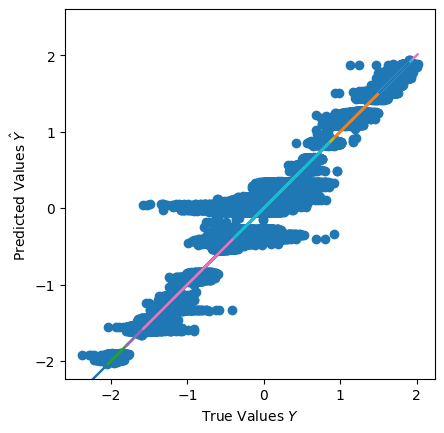

In [ ]:
# plot
import matplotlib.pyplot as plt

plt.scatter(Y_test, model.predict(X_test_reshaped))
plt.xlabel("True Values $Y$")
plt.ylabel("Predicted Values $\hat{Y}$")
plt.axis("equal")
plt.axis("square")
plt.plot(Y_test, Y_test)
plt.show()

# 적용시킬 목소리 파일 입력받기

In [ ]:
out_filepath = '/content/audio/audio.wav'

In [ ]:
# WAV 파일 읽기
y, sr = librosa.load(out_filepath)

# MFCCs 추출
n_mfcc = 20  # MFCCs의 차원 수
n_fft = 2048  # FFT 크기
hop_length = 512  # 프레임 이동 간격

# MFCCs 추출
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

# 원하는 행의 개수를 지정
num_rows = 329
# MFCCs 데이터를 2차원 행렬로 변환
mfcc_matrix_ = np.empty((0, n_mfcc))

# MFCCs 데이터를 행 단위로 추가
for i in range(num_rows):
    start_frame = i * (mfccs.shape[1] // num_rows)
    end_frame = (i + 1) * (mfccs.shape[1] // num_rows)
    mfcc_sequence = mfccs[:, start_frame:end_frame]
    mfcc_matrix_ = np.vstack((mfcc_matrix_, mfcc_sequence.T))  # .T를 통해 전치하여 (n_mfcc, 프레임 수) 형태로

# 결과 확인
print("2D 행렬의 형태:", mfcc_matrix_.shape)

2D 행렬의 형태: (329, 20)


In [ ]:
mfcc_matrix_

array([[-3.89145142e+02,  9.92002411e+01,  2.76201859e+01, ...,
         4.91820574e+00,  7.26293278e+00,  1.33049905e+00],
       [-2.76436981e+02,  6.17430573e+01,  1.96106129e+01, ...,
         2.01745758e+01,  4.54727173e+00,  8.67536783e-01],
       [-1.93924576e+02,  4.58624725e+01,  1.37431660e+01, ...,
         2.15107250e+01,  6.24473453e-01, -3.28706980e+00],
       ...,
       [-2.04391617e+02,  1.11690598e+02, -1.71410294e+01, ...,
         1.22319403e+01, -7.06464481e+00, -1.35376811e+00],
       [-1.88997131e+02,  1.46041946e+02, -2.72662210e+00, ...,
         4.08183479e+00, -8.46849680e-01,  1.72464252e-02],
       [-1.35380219e+02,  1.44040054e+02, -8.58210564e+00, ...,
         4.54561234e+00, -2.09507537e+00,  1.15694189e+00]])

In [ ]:
y=model(mfcc_matrix_)             # 예측된 표준화 좌표

In [ ]:
y

<tf.Tensor: shape=(329, 40), dtype=float32, numpy=
array([[-1.9588535 , -1.219673  , -0.5033467 , ...,  0.1194309 ,
         0.28040504,  0.23261008],
       [-2.0151355 , -1.2510682 , -0.5280951 , ...,  0.14859791,
         0.35406372,  0.30300468],
       [-2.0177135 , -1.2558832 , -0.523826  , ...,  0.15972678,
         0.3604304 ,  0.3072246 ],
       ...,
       [-1.9837039 , -1.2276936 , -0.51248914, ...,  0.13453455,
         0.33091655,  0.2936641 ],
       [-1.9892266 , -1.2328713 , -0.5183383 , ...,  0.13007206,
         0.32270828,  0.27839684],
       [-1.9834273 , -1.227984  , -0.51902807, ...,  0.12357557,
         0.31760716,  0.27532226]], dtype=float32)>

# 적용할 동영상 프레임 단위로 랜드마크 데이터프레임화

In [ ]:
df = pd.read_csv("/content/gdrive//MyDrive/Wav2Lip/csv/KakaoTalk_20231119_220036247.csv",index_col=0)    # 딥페이크 영상 프레임 단위로 랜드마크 저장

In [ ]:
# 그 중 기준이 되는 프레임1
d=df.iloc[319,:]

In [ ]:
# x 좌표와 y 좌표 구분
x_cols = d[:20]  # x 열
y_cols = d[20:]  # y 열

import numpy as np
mx=np.mean(x_cols)
my=np.mean(y_cols)
sx=np.std(x_cols)
sy=np.std(y_cols)


In [ ]:
y=np.copy(y)
y_df = pd.DataFrame(y, columns=df3.columns)

In [ ]:
# 기준 프레임에 역표준화하여 적용시킴
y_df.iloc[:, :20]=(y_df.iloc[:, :20].mul(sx)).add(mx)
y_df.iloc[:, 20:]=(y_df.iloc[:, 20:].mul(sy)).add(my)

In [ ]:
y_df

,Landmark_1_X,Landmark_2_X,Landmark_3_X,Landmark_4_X,Landmark_5_X,Landmark_6_X,Landmark_7_X,Landmark_8_X,Landmark_9_X,Landmark_10_X,...,Landmark_11_Y,Landmark_12_Y,Landmark_13_Y,Landmark_14_Y,Landmark_15_Y,Landmark_16_Y,Landmark_17_Y,Landmark_18_Y,Landmark_19_Y,Landmark_20_Y
0,610.283508,621.761292,632.884216,640.581848,648.343933,659.051208,668.801758,659.906189,650.205933,641.899719,...,308.437622,302.822388,289.617523,285.055908,285.601013,283.890045,286.112213,290.374756,292.227692,291.677551
1,609.409546,621.273804,632.499878,640.566040,648.535950,659.192505,668.500610,660.436096,650.920471,642.177063,...,309.233521,303.600311,290.216400,285.401459,285.760101,283.646149,284.102081,290.710480,293.075592,292.487854
2,609.369507,621.199036,632.566162,640.684326,648.460999,659.223328,668.592346,660.432373,651.100769,642.158447,...,309.322327,303.610413,290.103088,285.410645,285.664948,283.755920,283.856293,290.838593,293.148865,292.536407
3,609.906738,621.519897,632.727295,640.646729,648.327515,658.964294,668.349487,660.098999,650.847229,642.088013,...,308.913910,303.289612,289.962982,285.395813,285.692566,283.840820,284.394409,290.729156,292.901794,292.327271
4,609.749146,621.440735,632.648438,640.578003,648.394531,658.992676,668.410034,660.196899,650.778625,642.025146,...,308.905426,303.313843,290.014465,285.349060,285.719727,283.752228,284.595642,290.670898,292.837250,292.223450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,611.022461,621.915833,633.452698,640.907898,648.139343,659.169189,669.763000,659.402527,649.404053,641.106445,...,307.369171,301.561066,288.453735,284.328735,285.015686,284.435028,289.217896,290.145538,290.840546,290.015533
325,610.946350,621.848877,633.436768,640.937134,648.150940,659.192078,669.764160,659.443054,649.471008,641.089905,...,307.413727,301.587860,288.464264,284.337708,284.995544,284.443848,289.095184,290.194061,290.881927,290.025818
326,609.897644,621.636719,632.742249,640.519226,648.278137,659.000671,668.662781,660.109985,650.703186,642.176514,...,308.970886,303.364960,289.890320,285.320160,285.745758,283.758514,284.791077,290.548615,292.809143,292.380341
327,609.811890,621.556335,632.651428,640.495605,648.436218,659.088989,668.625122,660.195801,650.563171,642.110474,...,308.897095,303.311646,289.992737,285.266663,285.754578,283.693634,285.020538,290.497253,292.714661,292.204590


In [ ]:
# 기준이 되는 프레임 내 x,y 좌표 min값 빼줌
y_df.iloc[:, :20]=y_df.iloc[:, :20].sub(y_df.iloc[:, :20].min(axis=1), axis=0)
y_df.iloc[:, 20:]=y_df.iloc[:, 20:].sub(y_df.iloc[:, 20:].min(axis=1), axis=0)

In [ ]:
y_df

,Landmark_1_X,Landmark_2_X,Landmark_3_X,Landmark_4_X,Landmark_5_X,Landmark_6_X,Landmark_7_X,Landmark_8_X,Landmark_9_X,Landmark_10_X,...,Landmark_11_Y,Landmark_12_Y,Landmark_13_Y,Landmark_14_Y,Landmark_15_Y,Landmark_16_Y,Landmark_17_Y,Landmark_18_Y,Landmark_19_Y,Landmark_20_Y
0,0.0,11.477783,22.600708,30.298340,38.060425,48.767700,58.518250,49.622681,39.922424,31.616211,...,37.232727,31.617493,18.412628,13.851013,14.396118,12.685150,14.907318,19.169861,21.022797,20.472656
1,0.0,11.864258,23.090332,31.156494,39.126404,49.782959,59.091064,51.026550,41.510925,32.767517,...,38.294037,32.660828,19.276917,14.461975,14.820618,12.706665,13.162598,19.770996,22.136108,21.548370
2,0.0,11.829529,23.196655,31.314819,39.091492,49.853821,59.222839,51.062866,41.731262,32.788940,...,38.576111,32.864197,19.356873,14.664429,14.918732,13.009705,13.110077,20.092377,22.402649,21.790192
3,0.0,11.613159,22.820557,30.739990,38.420776,49.057556,58.442749,50.192261,40.940491,32.181274,...,37.887909,32.263611,18.936981,14.369812,14.666565,12.814819,13.368408,19.703156,21.875793,21.301270
4,0.0,11.691589,22.899292,30.828857,38.645386,49.243530,58.660889,50.447754,41.029480,32.276001,...,37.858765,32.267181,18.967804,14.302399,14.673065,12.705566,13.548981,19.624237,21.790588,21.176788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,0.0,10.893372,22.430237,29.885437,37.116882,48.146729,58.740540,48.380066,38.381592,30.083984,...,36.741821,30.933716,17.826385,13.701385,14.388336,13.807678,18.590546,19.518188,20.213196,19.388184
325,0.0,10.902527,22.490417,29.990784,37.204590,48.245728,58.817810,48.496704,38.524658,30.143555,...,36.787354,30.961487,17.837891,13.711334,14.369171,13.817474,18.468811,19.567688,20.255554,19.399445
326,0.0,11.739075,22.844604,30.621582,38.380493,49.103027,58.765137,50.212341,40.805542,32.278870,...,37.855835,32.249908,18.775269,14.205109,14.630707,12.643463,13.676025,19.433563,21.694092,21.265289
327,0.0,11.744446,22.839539,30.683716,38.624329,49.277100,58.813232,50.383911,40.751282,32.298584,...,37.743164,32.157715,18.838806,14.112732,14.600647,12.539703,13.866608,19.343323,21.560730,21.050659


In [ ]:
# 적용하려는 동영상 프레임 당 x,y좌표 min값 더해줌(x,y min값 기준으로 재조정)
y_df.iloc[:, :20]=y_df.iloc[:, :20].add(df.iloc[:, :20].min(axis=1), axis=0)
y_df.iloc[:, 20:]=y_df.iloc[:, 20:].add(df.iloc[:, 20:].min(axis=1), axis=0)

In [ ]:
y_df

,Landmark_1_X,Landmark_2_X,Landmark_3_X,Landmark_4_X,Landmark_5_X,Landmark_6_X,Landmark_7_X,Landmark_8_X,Landmark_9_X,Landmark_10_X,...,Landmark_11_Y,Landmark_12_Y,Landmark_13_Y,Landmark_14_Y,Landmark_15_Y,Landmark_16_Y,Landmark_17_Y,Landmark_18_Y,Landmark_19_Y,Landmark_20_Y
0,613.0,624.477783,635.600708,643.298340,651.060425,661.767700,671.518250,662.622681,652.922424,644.616211,...,314.232727,308.617493,295.412628,290.851013,291.396118,289.685150,291.907318,296.169861,298.022797,297.472656
1,613.0,624.864258,636.090332,644.156494,652.126404,662.782959,672.091064,664.026550,654.510925,645.767517,...,315.294037,309.660828,296.276917,291.461975,291.820618,289.706665,290.162598,296.770996,299.136108,298.548370
2,613.0,624.829529,636.196655,644.314819,652.091492,662.853821,672.222839,664.062866,654.731262,645.788940,...,316.576111,310.864197,297.356873,292.664429,292.918732,291.009705,291.110077,298.092377,300.402649,299.790192
3,612.0,623.613159,634.820557,642.739990,650.420776,661.057556,670.442749,662.192261,652.940491,644.181274,...,315.887909,310.263611,296.936981,292.369812,292.666565,290.814819,291.368408,297.703156,299.875793,299.301270
4,613.0,624.691589,635.899292,643.828857,651.645386,662.243530,671.660889,663.447754,654.029480,645.276001,...,314.858765,309.267181,295.967804,291.302399,291.673065,289.705566,290.548981,296.624237,298.790588,298.176788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,614.0,624.893372,636.430237,643.885437,651.116882,662.146729,672.740540,662.380066,652.381592,644.083984,...,316.741821,310.933716,297.826385,293.701385,294.388336,293.807678,298.590546,299.518188,300.213196,299.388184
325,614.0,624.902527,636.490417,643.990784,651.204590,662.245728,672.817810,662.496704,652.524658,644.143555,...,321.787354,315.961487,302.837891,298.711334,299.369171,298.817474,303.468811,304.567688,305.255554,304.399445
326,614.0,625.739075,636.844604,644.621582,652.380493,663.103027,672.765137,664.212341,654.805542,646.278870,...,325.855835,320.249908,306.775269,302.205109,302.630707,300.643463,301.676025,307.433563,309.694092,309.265289
327,614.0,625.744446,636.839539,644.683716,652.624329,663.277100,672.813232,664.383911,654.751282,646.298584,...,329.743164,324.157715,310.838806,306.112732,306.600647,304.539703,305.866608,311.343323,313.560730,313.050659


# 동영상 만들기

In [ ]:
import cv2
import os
# 각 이미지에 대해 랜드마크 좌표 읽어서 이미지 변형 및 저장
for i in range(len(y_df)):
    x_coords = y_df.iloc[i, :20].values
    y_coords = y_df.iloc[i, 20:].values
    landmarks = np.array(pd.DataFrame([x_coords, y_coords]).T)

    # 입술 부분의 좌표 추출
    lip_points = np.array(landmarks, dtype=np.int32)

    x_coords_in = y_df.iloc[i, 12:20].values
    y_coords_in = y_df.iloc[i, 32:].values
    landmarks_in = np.array(pd.DataFrame([x_coords_in, y_coords_in]).T)

    # 입안 부분의 좌표 추출
    mouth_inner_points = np.array(landmarks_in, dtype=np.int32)

    # 이미지 복사
    # 이미지 로드 (실제 이미지 파일 경로로 대체)
    frame_num=i
    image_path = f"/content/gdrive//MyDrive/Wav2Lip/original_frame/frame_{i}.jpg"
    image = cv2.imread(image_path)
    transformed_image = image.copy()

    # 입술 부분을 빨간색으로 칠하기
    cv2.fillPoly(transformed_image, [lip_points], color=(134, 100, 224))  # 빨간색 (BGR 순서)

    # 입안 부분을 어두운색으로 칠하기
    cv2.fillPoly(transformed_image, [mouth_inner_points], color=(64, 58, 52))  # 어두운색 (BGR 순서)

    # 변형된 이미지 저장
    output_dir="/content/gdrive//MyDrive/Wav2Lip/output_image"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"output_{i}.jpg")
    cv2.imwrite(output_path, transformed_image)


In [ ]:
import cv2
import imageio
import os

# 사진들이 있는 디렉토리 경로
photo_directory = "/content/gdrive//MyDrive/Wav2Lip/output_image/"

# 사진 파일들의 리스트 생성
photo_files = [os.path.join(photo_directory, f) for f in os.listdir(photo_directory) if f.endswith('.jpg')]

# 동영상 파일 경로
video_path = "/content/gdrive//MyDrive/Wav2Lip/mp4/video_new.mp4"

# 동영상 프레임의 크기 설정
frame_size = (1920, 1080)

# 원하는 동영상 길이 설정 (초)
desired_duration = 14

# 초당 프레임 수 계산
frame_rate = len(photo_files) / desired_duration

# VideoWriter 객체 생성
video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, frame_size)

# 사진들을 동영상에 추가
for photo in photo_files:
    img = cv2.imread(photo)
    img = cv2.resize(img, frame_size)
    video_writer.write(img)

# 사용이 끝난 객체들을 해제
video_writer.release()


# 영상에 소리 입히기

In [ ]:
!pip uninstall moviepy decorator
!pip install moviepy

Found existing installation: moviepy 1.0.3
Uninstalling moviepy-1.0.3:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/moviepy-1.0.3.dist-info/*
    /usr/local/lib/python3.10/dist-packages/moviepy/*
Proceed (Y/n)? Y
  Successfully uninstalled moviepy-1.0.3
Found existing installation: decorator 4.4.2
Uninstalling decorator-4.4.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/decorator-4.4.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/decorator.py
Proceed (Y/n)? Y
  Successfully uninstalled decorator-4.4.2
  Using cached moviepy-1.0.3-py3-none-any.whl
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipyth

In [ ]:
from moviepy.editor import VideoFileClip, AudioFileClip

# 동영상 파일 경로
video_path = "/content/gdrive//MyDrive/Wav2Lip/mp4/video_new.mp4"

# 소리 파일 경로
audio_path = '/content/audio/audio.wav'

# 출력 동영상 파일 경로
output_path = "/content/gdrive//MyDrive/Wav2Lip/mp4/video_final_new.mp4"

# 동영상 클립 로드
video_clip = VideoFileClip(video_path)

# 소리 클립 로드
audio_clip = AudioFileClip(audio_path)

# 소리를 동영상에 추가
video_clip = video_clip.set_audio(audio_clip)

# 결과를 파일로 저장
video_clip.write_videofile(output_path, codec="libx264", audio_codec="aac")


# 사용이 끝난 객체 해제
video_clip.close()
audio_clip.close()


Moviepy - Building video /content/gdrive//MyDrive/Wav2Lip/mp4/video_final_new.mp4.
MoviePy - Writing audio in video_final_newTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /content/gdrive//MyDrive/Wav2Lip/mp4/video_final_new.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive//MyDrive/Wav2Lip/mp4/video_final_new.mp4


In [ ]:
from IPython.display import display, HTML
from base64 import b64encode

def play_local_video(video_path):
    video_encoded = b64encode(open(video_path, "rb").read()).decode()
    video_tag = f'<video controls alt="test" src="data:video/mp4;base64,{video_encoded}" width="640" height="360">'
    display(HTML(data=video_tag))

# MP4 파일 재생
video_path = "/content/gdrive//MyDrive/Wav2Lip/mp4/video_final_new.mp4"
play_local_video(video_path)


# 텍스트를 입력받아 딥페이크 영상 만들어주는 함수

In [ ]:
def talkingyu(text) :
    # 샘플레이트 설정 (예: 44100Hz)
    sample_rate = 24000

    # 기본 오디오 데이터 생성 (예: 1초 길이의 무음)
    # np.zeros를 사용하여 모든 샘플이 0인 배열 생성
    duration = 1  # 1초
    audio_data = np.zeros(sample_rate * duration)

    # 데이터 타입을 32비트 부동소수점 형식으로 변환
    audio_data = audio_data.astype(np.float32)

    # WAV 파일로 저장
    wavfile.write('/content/audio/audio.wav', sample_rate, audio_data)

    # Chunk the text into smaller pieces then combine the generated audio
    #같은 대사 여러번 하는게.?

    #/content/datasets_yoo/tokens/yujaeseog17.npz
    # generation settings
    voice_name_1= "/content/bark/bark/assets/prompts/ko_speaker_4.npz"
    voice_name_2 = "/content/drive/MyDrive/datasets_yoo/tokens/yujaeseog61.npz"
    out_filepath = '/content/audio/audio.wav'

    semantic_temp = 0.7 #높은 값 (예: 1 이상)은 더 다양하고 예측 불가능한 텍스트를 생성하는 데 기여합니다.
    semantic_top_k = 100 #모델이 다음 단어를 선택할 때 고려하는 후보 단어의 집합을 k개의 가장 높은 확률을 가진 단어로 제한합니다.
    semantic_top_p = 0.99

    coarse_temp = 0.7
    coarse_top_k = 100
    coarse_top_p = 0.95

    fine_temp = 0.7

    use_semantic_history_prompt = True
    use_coarse_history_prompt = False
    use_fine_history_prompt = True

    use_last_generation_as_history = False #지난 루프가..

    if use_rvc:
        index_rate = 0.75
        f0up_key = -6
        filter_radius = 3
        rms_mix_rate = 0.25
        protect = 0.33
        resample_sr = SAMPLE_RATE
        f0method = "harvest" #harvest or pm

    texts = split_and_recombine_text(text)

    all_parts = []
    for i, text in tqdm(enumerate(texts), total=len(texts)):
        full_generation, audio_array = generate_with_settings(
            text,
            semantic_temp=semantic_temp,
            semantic_top_k=semantic_top_k,
            semantic_top_p=semantic_top_p,
            coarse_temp=coarse_temp,
            coarse_top_k=coarse_top_k,
            coarse_top_p=coarse_top_p,
            fine_temp=fine_temp,
            voice_name_1=voice_name_1,
            voice_name_2=voice_name_2,
            use_semantic_history_prompt=use_semantic_history_prompt,
            use_coarse_history_prompt=use_coarse_history_prompt,
            use_fine_history_prompt=use_fine_history_prompt,
            output_full=True
        )
        if use_last_generation_as_history:
            # save to npz
            os.makedirs('_temp', exist_ok=True)
            np.savez_compressed(
                '_temp/history.npz',
                semantic_prompt=full_generation['semantic_prompt'],
                coarse_prompt=full_generation['coarse_prompt'],
                fine_prompt=full_generation['fine_prompt'],
            )
            voice_name = '_temp/history.npz'
        write_wav(out_filepath.replace('.wav', f'_{i}') + '.wav', SAMPLE_RATE, audio_array)

        if use_rvc:
            try:
                audio_array = vc_single(0,out_filepath.replace('.wav', f'_{i}') + '.wav',f0up_key,None,f0method,index_path,index_rate, filter_radius=filter_radius, resample_sr=resample_sr, rms_mix_rate=rms_mix_rate, protect=protect)
            except:
                audio_array = vc_single(0,out_filepath.replace('.wav', f'_{i}') + '.wav',f0up_key,None,'pm',index_path,index_rate, filter_radius=filter_radius, resample_sr=resample_sr, rms_mix_rate=rms_mix_rate, protect=protect)
            write_wav(out_filepath.replace('.wav', f'_{i}') + '.wav', SAMPLE_RATE, audio_array)
        all_parts.append(audio_array)

    audio_array = np.concatenate(all_parts, axis=-1)

    # save audio
    write_wav(out_filepath, SAMPLE_RATE, audio_array)

    # play audio
    Audio(audio_array, rate=SAMPLE_RATE)

    # WAV 파일 읽기
    y, sr = librosa.load(out_filepath)

    # MFCCs 추출
    n_mfcc = 20  # MFCCs의 차원 수
    n_fft = 2048  # FFT 크기
    hop_length = 512  # 프레임 이동 간격

    # MFCCs 추출
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # 원하는 행의 개수를 지정
    num_rows = 329
    # MFCCs 데이터를 2차원 행렬로 변환
    mfcc_matrix_ = np.empty((0, n_mfcc))

    # MFCCs 데이터를 행 단위로 추가
    for i in range(num_rows):
        start_frame = i * (mfccs.shape[1] // num_rows)
        end_frame = (i + 1) * (mfccs.shape[1] // num_rows)
        mfcc_sequence = mfccs[:, start_frame:end_frame]
        mfcc_matrix_ = np.vstack((mfcc_matrix_, mfcc_sequence.T))  # .T를 통해 전치하여 (n_mfcc, 프레임 수) 형태로

    y=model(mfcc_matrix_)             # 예측된 표준화 좌표
    y=np.copy(y)
    y_df = pd.DataFrame(y, columns=df3.columns)

    # 기준 프레임에 역표준화하여 적용시킴
    y_df.iloc[:, :20]=(y_df.iloc[:, :20].mul(sx)).add(mx)
    y_df.iloc[:, 20:]=(y_df.iloc[:, 20:].mul(sy)).add(my)

    # 기준이 되는 프레임 내 x,y 좌표 min값 빼줌
    y_df.iloc[:, :20]=y_df.iloc[:, :20].sub(y_df.iloc[:, :20].min(axis=1), axis=0)
    y_df.iloc[:, 20:]=y_df.iloc[:, 20:].sub(y_df.iloc[:, 20:].min(axis=1), axis=0)

    # 적용하려는 동영상 프레임 당 x,y좌표 min값 더해줌(x,y min값 기준으로 재조정)
    y_df.iloc[:, :20]=y_df.iloc[:, :20].add(df.iloc[:, :20].min(axis=1), axis=0)
    y_df.iloc[:, 20:]=y_df.iloc[:, 20:].add(df.iloc[:, 20:].min(axis=1), axis=0)

    for i in range(len(y_df)):
        x_coords = y_df.iloc[i, :20].values
        y_coords = y_df.iloc[i, 20:].values
        landmarks = np.array(pd.DataFrame([x_coords, y_coords]).T)

        # 입술 부분의 좌표 추출
        lip_points = np.array(landmarks, dtype=np.int32)

        x_coords_in = y_df.iloc[i, 12:20].values
        y_coords_in = y_df.iloc[i, 32:].values
        landmarks_in = np.array(pd.DataFrame([x_coords_in, y_coords_in]).T)

        # 입안 부분의 좌표 추출
        mouth_inner_points = np.array(landmarks_in, dtype=np.int32)

        # 이미지 복사
        # 이미지 로드 (실제 이미지 파일 경로로 대체)
        frame_num=i
        image_path = f"/content/gdrive//MyDrive/Wav2Lip/original_frame/frame_{i}.jpg"
        image = cv2.imread(image_path)
        transformed_image = image.copy()

        # 입술 부분을 빨간색으로 칠하기
        cv2.fillPoly(transformed_image, [lip_points], color=(134, 100, 224))  # 빨간색 (BGR 순서)

        # 입안 부분을 어두운색으로 칠하기
        cv2.fillPoly(transformed_image, [mouth_inner_points], color=(64, 58, 52))  # 어두운색 (BGR 순서)

        # 변형된 이미지 저장
        output_dir="/content/gdrive//MyDrive/Wav2Lip/output_image"
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f"output_{i}.jpg")
        cv2.imwrite(output_path, transformed_image)

    # 사진들이 있는 디렉토리 경로
    photo_directory = "/content/gdrive//MyDrive/Wav2Lip/output_image/"

    # 사진 파일들의 리스트 생성
    photo_files = [os.path.join(photo_directory, f) for f in os.listdir(photo_directory) if f.endswith('.jpg')]

    # 동영상 파일 경로
    video_path = "/content/gdrive//MyDrive/Wav2Lip/mp4/video_new.mp4"

    # 동영상 프레임의 크기 설정
    frame_size = (1920, 1080)

    # 원하는 동영상 길이 설정 (초)
    desired_duration = 14

    # 초당 프레임 수 계산
    frame_rate = len(photo_files) / desired_duration

    # VideoWriter 객체 생성
    video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, frame_size)

    # 사진들을 동영상에 추가
    for photo in photo_files:
        img = cv2.imread(photo)
        img = cv2.resize(img, frame_size)
        video_writer.write(img)

    # 사용이 끝난 객체들을 해제
    video_writer.release()

    from moviepy.editor import VideoFileClip, AudioFileClip

    # 동영상 파일 경로
    video_path = "/content/gdrive//MyDrive/Wav2Lip/mp4/video_new.mp4"

    # 소리 파일 경로
    audio_path = '/content/audio/audio.wav'

    # 출력 동영상 파일 경로
    output_path = "/content/gdrive//MyDrive/Wav2Lip/mp4/video_final_new.mp4"

    # 동영상 클립 로드
    video_clip = VideoFileClip(video_path)

    # 소리 클립 로드
    audio_clip = AudioFileClip(audio_path)

    # 소리를 동영상에 추가
    video_clip = video_clip.set_audio(audio_clip)

    # 결과를 파일로 저장
    video_clip.write_videofile(output_path, codec="libx264", audio_codec="aac")


    # 사용이 끝난 객체 해제
    video_clip.close()
    audio_clip.close()

    # MP4 파일 재생
    return play_local_video("/content/gdrive//MyDrive/Wav2Lip/mp4/video_final_new.mp4")